# CS109 Final Project Process Book

## Background & Motivation
Social media and entertainment are such pervasive parts of millennials' lives. We want to study the intersection of these two. Is it possible to predict box office success of film through sentiments expressed on social media? Stay tuned for more!

## Table of Contents
* [CS109 Final Project Process Book](#CS109-Final-Project-Process-Book)
	* [Milestone 1: Scrape and prepare data before thanksgiving](#Milestone-1:-Scrape-and-prepare-data-before-thanksgiving)
		* [Scraping and cleaning Box Office Mojo](#Scraping-and-cleaning-Box-Office-Mojo)
		* [Loading and preparing IMDB review dataset](#Loading-and-preparing-IMDB-review-dataset)
		* [Loading and preparing AFINN dictionary](#Loading-and-preparing-AFINN-dictionary)
	* [Milestone 2: Analysing and visualizing the data](#Milestone-2:-Analysing-and-visualizing-the-data)
		* [Descriptive statistics](#Descriptive-statistics)
		* [Analysis](#Analysis)
        * [Visualization](#Visualization)
	* [Milestone 3: Video and finishing touches](#Milestone-3:-Video-and-finishing-touches)
		* [Screencast video](#Screencast-video)
		* [Website](#Website)
		* [Finishing touches](#Finishing-touches)

In [897]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import math
from sklearn.svm import LinearSVC

## Milestone 1: Scrape and prepare data before thanksgiving

For our project we will be using data from 3 different sources
 <ul><b>Box Office Mojo (BOM)</b> (http://www.boxofficemojo.com) is a website that aggregates, in a table, a list of all movies released in a year and attributes such as how much it grossed in the opening week, how much it grossed in total and how long it aired for </ul>
 <ul><b>Large Movie Review Dataset</b> (http://ai.stanford.edu/~amaas/data/sentiment/) is a polarized dataset of movie reviews from IMDB prepared by Maas et al from Stanford. The dataset contains 25,000 entries in the training set and 25,000 entries in the test set. </ul>
 <ul><b>AFINN-111 Dictionary</b> (http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=60100) is a dictionary list of 2477 english words and phrases rated for valence with an integer from -5 to 5. Originally prepared by Finn Årup Nielsen</ul><br>
In this first milestone, we will get all the data into a format that we can start running analysis on!

### Scraping and cleaning Box Office Mojo

First we import the `requests` and `BeautifulSoup` libraries to make working with HTTP requests easier, and then easily transfer HTML content to Python data structures.

In [2]:
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

Secondly, we prepare the data frame `movie_df` to store the data that we will scrape from BOM. We give this dataframe 9 columns: <br>
    * ranking: the ranking of the movie in its release year by gross
    * title: movie title
    * gross: how much the movie grossed while in theatres
    * Total_theaters: the total number of theaters that showed this movie
    * opening_gross: how much the movie grossed in the opening weekend (Fri-Sun)
    * opening_theaters: the total number of theaters that showed this movie in the opening weekend (Fri-Sun)
    * open_date: date of opening
    * close_date: date of closing
    * year: year of release

In [3]:
bom_df = pd.DataFrame(columns=['close_date', 'gross', 'open_date', 'opening_gross', 'opening_theaters','ranking','title','total_theaters','year'])

Now we write a function `rowInfoGrabber` that we will call in a loop over the table on the BOM webpage to grab the attributes and save them into the corresponding columns in `movie_df`.

In [4]:
def rowInfoGrabber(r):
    info = []
    # Ranking
    info.append(int(r.find("font").get_text()))
    # Title
    info.append(r.find("a").get_text())
    # Gross
    info.append(int(r.find("td", attrs={"align":"right"}).find("b").get_text().strip("$").replace(",","")))
    '''
    For the next 3 categories, we need to deal with the 2000 Anomaly "Fantasia" where there are missing numbers.
    In this case I have chosen to replace the missing values 'N/A' with the values from 'Final Destination', which
    if right above it in the movie table and differs in gross income by about $1 million, which is a small 
    difference. See the picture below for a snapshot of the anomaly in the movie table from 2000.
    '''
    # Total number of theaters
    if r.find_all("td",attrs={"align":"right"})[1].find("font").get_text().replace(",","") == 'N/A':
        info.append(2587)
    else:
        info.append(int(r.find_all("td",attrs={"align":"right"})[1].find("font").get_text().replace(",","")))
    # Opening Gross
    if r.find_all("td", attrs={"align":"right"})[2].find("font").get_text().strip("$").replace(",","") == 'N/A':
        info.append(10015822)
    else: 
        info.append(int(r.find_all("td", attrs={"align":"right"})[2].find("font").get_text().strip("$").replace(",","")))
    # Opening Number of Theaters
    if r.find_all("td", attrs={"align":"right"})[3].find("font").get_text().replace(",","") == 'N/A':
        info.append(2587)
    else:
        info.append(int(r.find_all("td", attrs={"align":"right"})[3].find("font").get_text().replace(",","")))
    # Date of Opening
    info.append(r.find_all("td", attrs={"align":"right"})[4].find("a").get_text())
    # Date of Closing: Before 2002 they didn't have a "closing" date in their tables. We must account for this.
    if (len(r.find_all("td", attrs={"align":"right"})) <= 5):
        info.append('-')
    else:
        info.append(r.find_all("td", attrs={"align":"right"})[5].find("font").get_text())
    return info

This is the image: <image src=“Example.png”>

In [5]:
fields = ["ranking", "title", "gross", "total_theaters", "opening_gross", "opening_theaters", "open_date", "close_date"]

Finally we're ready to scrape! <br>
Because IMDB was created in 1990, we will scrape that far back in BOM. So we're scraping the past 26 years (1990 - 2015). Also note that because the HTML was changed starting in 2001, our scraping will be a little different before and after then.

In [49]:
%%time
years = [1990 + i for i in range(26)]
for year in years:
    pageText = requests.get("http://www.boxofficemojo.com/yearly/chart/?yr=%(yr)d&p=.htm" % {'yr':year})
    soup = BeautifulSoup(pageText.text, "html.parser")
    movieTable = soup.find("td", attrs={"colspan":"3"})
    movieRows = movieTable.find("table").find_all("tr")[2:102]
    movie_dicts = [dict(zip(fields, rowInfoGrabber(row))) for row in movieRows]
    year_df = pd.DataFrame(movie_dicts)
    year_df['year'] = year
    bom_df = bom_df.append(year_df, ignore_index=True)
    time.sleep(1)

KeyboardInterrupt: 

In [ ]:
print bom_df.shape
bom_df.head()

Because some films do not have a close date, we will have to be careful with the close date! Next, we combine the `close_date`, `open_date` and `year` columns into two columns `close_date` and `open_date` that are time series. This will make it easier for us to work with the data in the future. 

In [ ]:
# splitting the close_date and open_date into the respective month and day
bom_df['close_month'] = bom_df['close_date'].map(lambda x: '0' if x=='-' else x[:x.find('/')])
bom_df['close_day'] = bom_df['close_date'].map(lambda x: '0' if x=='-' else x[x.find('/')+1:len(x)])
bom_df['open_month'] = bom_df['open_date'].map(lambda x: x[:x.find('/')])
bom_df['open_day'] = bom_df['open_date'].map(lambda x: x[x.find('/')+1:len(x)])

# dropping the old close_date and open_date
bom_df = bom_df.drop('close_date', 1)
bom_df = bom_df.drop('open_date', 1)

# creating an open_year by turning the year column into a string and getting rid of trailing bits
bom_df['open_year'] = bom_df.year.astype(str)
bom_df['open_year'] = bom_df.open_year.map(lambda x: x[:x.find('.')])

# creating a close_year column, by looking at whether the close month is earlier/later than the open month in the year
close_month = bom_df['close_month'].astype(int)
open_month = bom_df['open_month'].astype(int)
year = bom_df['year'].astype(int)
close_year=[]
for i in range (0, len(year)):
    if close_month[i] >= open_month[i]:
        close_year.append(year[i])
    else:
        close_year.append(year[i]+1) 
bom_df['close_year'] = close_year
bom_df['close_year'] = bom_df['close_year'].astype(str)

In [ ]:
# making close_date and open_date by concatenating the year, month and day
import datetime
close_date = []
for index, row in bom_df.iterrows():
    if row.close_day != '0':
        close_date.append(datetime.datetime(int(row.close_year), int(row.close_month), int(row.close_day)))
    else: 
        close_date.append(None)
bom_df['close_date'] = close_date

bom_df['open_date']=bom_df.open_year + '-' + bom_df.open_month + '-' + bom_df.open_day
bom_df['open_date']=bom_df['open_date'].apply(pd.datetools.parse)

Let's take a look at the data, now!

In [ ]:
bom_df.head()

Let's take a look at if we can get the run times for each movie!

In [ ]:
run_time=[]
for index, row in bom_df.iterrows():
    if row.close_date != None:
        run_time.append(row['close_date']-row['open_date'])
    else: 
        run_time.append('N/A')

Looks like the data is ready for us to use! Let's save this data so we're ready to use it next time. 

In [ ]:
! pip install pymongo

In [ ]:
# Save the movie Dictionaries corresponding to each row of the BoxOfficeMojo table.
import json # (dong)
import pymongo
from bson import json_util

# Make a dictionary out of the dataset for storage in JSON format.
movieSaved = {feature: bom_df[feature].values.tolist() for feature in bom_df.columns.values}
fp = open("allMovies.json","w")
json.dump(movieSaved, fp, default=json_util.default)
fp.close()

### Loading and preparing IMDB review dataset

We have cleaned up our IMDB review dataset in the ipython notebook `IMDB_reviews.ipynb`. From that notebook we have been able to save dictionaries of our data, which we will now call. 

In [ ]:
with open("train_df_dict.json", "r") as fd:
    train_df_dict = json.load(fd)
with open("test_df_dict.json", "r") as fd:
    test_df_dict = json.load(fd)

In [ ]:
train_df = pd.DataFrame(train_df_dict)
test_df = pd.DataFrame(test_df_dict)

The Stanford group distinguishes between train and test because this was relevant for their project. This may prove to be useful later, so we will keep two separate dataframes. However, for our purposes at the moment, we can combine them since the BOM data will serve as our true data set.

In [ ]:
IMDB_df = train_df.append(test_df)

We want to figure out which movies from IMDB_df are also present in our BOM DF. So let's get all the movie titles in our BOM table. 

In [ ]:
BOM_movie_list = bom_df.title.values.tolist()

Now let's create a mask over IMDB_df, the boolean values of which indicate whether or not a movie is in the BOM list.

In [ ]:
movie_mask = [(movie in BOM_movie_list) for movie in IMDB_df.movie_name]

In [ ]:
sum(movie_mask)

We can now create our IMDB data frame with only those movies that also appear in the BOM tables from 1990 - 2015. 

In [ ]:
IMDB_dftouse=IMDB_df[movie_mask]

Finally we want to save our dictionary of IMDB_dftouse into a JSON file for storage.

In [ ]:
IMDB_dftouse_dict = {feature: IMDB_dftouse[feature].values.tolist() for feature in IMDB_dftouse.columns.values}
fp = open("IMDB_dftouse_dict.json","w")
json.dump(IMDB_dftouse_dict, fp)
fp.close()

In [18]:
# Reopen
with open("IMDB_dftouse_dict.json", "r") as fd:
    IMDB_dftouse_dict = json.load(fd)
IMDB_dftouse = pd.DataFrame(IMDB_dftouse_dict)

## Analyzing and Saving Review Attributes Using labMT Happiness Dictionary

Now let's download labMT, a word score list for sentiment analysis containing over 10,000 words. The file contains a "happiness" value, and ranks words by their happiness. It also includes mean and standard deviation, Twitter rank and Google rank.

In [8]:
url = 'http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0026752.s001'
labmt = pd.read_csv(url, skiprows=2, sep='\t', index_col=0)

In [9]:
labmt.head()

happiness_rank  happiness_average  happiness_standard_deviation twitter_rank google_rank nyt_rank lyrics_rank
word                                                                                                                    
laughter                1               8.50                        0.9313         3600          --       --        1728
happiness               2               8.44                        0.9723         1853        2458       --        1230
love                    3               8.42                        1.1082           25         317      328          23
happy                   4               8.30                        0.9949           65        1372     1313         375
laughed                 5               8.26                        1.1572         3334        3542       --        2332

Now let's create a happiness dictionary of (word, valence) pairs where each valence is that word's original valence minus the average valence.

In [10]:
average = labmt.happiness_average.mean()
happiness = (labmt.happiness_average - average).to_dict()

In [11]:
print "Score(happy): ", happiness['happy']
print "Score(miserable): ", happiness['miserable']
print "Best score: ", max(happiness.values())
print "Worst score: ", min(happiness.values())

Score(happy):  2.92476032088
Score(miserable):  -2.83523967912
Best score:  3.12476032088
Worst score:  -4.07523967912


In [12]:
# Save to disc
fp = open("happiness.json","w")
json.dump(happiness, fp)
fp.close()

In [13]:
# Reopen
with open("happiness.json", "r") as fp:
    happiness = json.load(fp)

Now let's collect several attributes from a given review's text body, and save all valuable information into a new data frame. First we define a function that removes stop words (all non important words from a valence perspective) from a text body.

In [14]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS
punctuation = list('.,;:!?()[]{}`''\"@#$%^&*+-|-=~_')

def removeStopWords(text, stopwords = stopwords):
    new_text = ""
    for word in text.split():
        if word not in stopwords:
            while len(word) != 0 and word[-1] in punctuation:
                word = word[:len(word)-1]
            new_text += word + ' '
    return new_text

Now we'll write a function that returns total happiness, average happiness, total scorable words, and percentage of scorable words in a given review text.

In [15]:
'''
Name: getValenceInfo()
Inputs: review text, dictionary of happiness
Returns: a 4-tuple of (happiness total, happiness average, total # of scorable words, % of scorable words)
'''
def getValenceInfo(text, valenceDict):
    total_words = len(text.split())
    happiness_total, count_relevant = 0, 0
    for word in text.split():
        if word in valenceDict.keys():
            count_relevant += 1
            happiness_total += valenceDict[word]
    if count_relevant != 0: 
        avg_valence = 1.*happiness_total/count_relevant
    else: 
        avg_valence = 0
    return happiness_total, avg_valence, total_words, 1.*count_relevant / total_words

Now we'll write a function that, given a data frame, returns a new data frame with the concatenation of valence (happiness) info in 4 new columns: valence sum, valence average, # of scorable words, % of scorable words.

In [16]:
'''
Name: getAllInfo
Input: data frame, happiness dictionary, list of stop words
Returns: a new data frame with 4 new columns: valence_sum, valence_avg, n_scorables, pct_scorables
'''
def getAllInfo(df, valenceDict, stopwords): 
    valence_suml, valence_avgl, review_lenl, review_fractionl = [], [], [], []
    for i, row in df.iterrows():
        cleaned_review = removeStopWords(row['text'], stopwords)
        valence_sum, valence_avg, review_len, review_fraction = getValenceInfo(cleaned_review, valenceDict)
        valence_suml.append(valence_sum)
        valence_avgl.append(valence_avg)
        review_lenl.append(review_len)
        review_fractionl.append(review_fraction)
    conc = pd.DataFrame({'valence_sum': valence_suml, 'valence_avg':valence_avgl ,'n_scorables': review_lenl, 
                         'pct_scorables': review_fractionl})
    return pd.concat([df, conc], axis=1)

Now let's create a new dataframe `valence_df` with the valence statistics run on our IMDB_df. This code takes a few minutes to run.

In [20]:
%%time
valence_df = getAllInfo(IMDB_dftouse, happiness, stopwords)

In [ ]:
valence_df.head()

In [ ]:
# Convert True/False to 1/0: needed to make valence_df JSON serializable, also better practice
valence_df.positive = 1.0*valence_df.positive

In [ ]:
# Save to disc
fp = open("valence_df_dict.json","w")
json.dump(valence_df.to_dict(), fp)
fp.close()

In [21]:
# Reopen
with open("valence_df_dict.json", "r") as fp:
    valence_df_dict = json.load(fp)
valence_df = pd.DataFrame(valence_df_dict)

## Milestone 2: Analysing and visualizing the data

### Descriptive statistics

### Does valence correlate with stars given?

In [956]:
dftouse = dftouse[dftouse['title'] >50]
dftouse.shape
dftouse.head()
# dftouse.shape


valence_avg_var  valence_sum_var      gross  n_scorables  pct_scorables  title  valence_avg  valence_sum  adj_opening_gross  adj_opening_gross_bin  abs_valence_avg
title                                                                                                                                                                                            
Home Alone                           0.091807      1020.748703  285761243       125.66       0.603929    100     0.748638    51.992367           17081997                      1         0.239733
Ghost                                0.078989       665.653928  217631306       148.29       0.576205    100     0.511307    38.345363           12191540                      1         0.002402
Dances with Wolves                   0.066500       846.466030  184208848       143.96       0.585237    100     0.533462    41.303954             598257                      1         0.024557
Pretty Woman                         0.083728      1669.392542  178406268       137.94       0.550992    100     0.668805    50.780291           11280591                      1         0.159899
Teenage Mutant Ninja Turtles         0.086789       801.245305  135265915       144.18       0.557210    100     0.444856    33.939885           25398367                      1         0.064049

In [990]:
dftouse3.head()
dftouse3['stars']=dftouse3['stars'].map(int())

TypeError: 'int' object is not callable

In [992]:
def isNA(input):
    if input=='N/A':
        return True
    else:
        return False

dftouse3 = dftouse2[~dftouse2.valence_avg.map(np.isnan)]
dftouse3 = dftouse3[~dftouse3.stars.map(isNA)]
dftouse3['stars'] = dftouse3['stars'].astype(int)

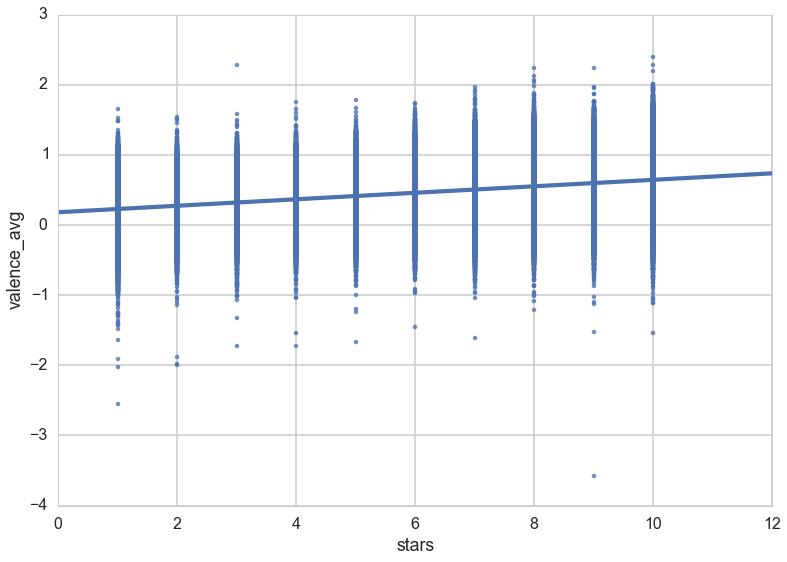

In [993]:
# we do not track the star ratings very well...
sns.regplot(y="valence_avg", x="stars", data=dftouse3)

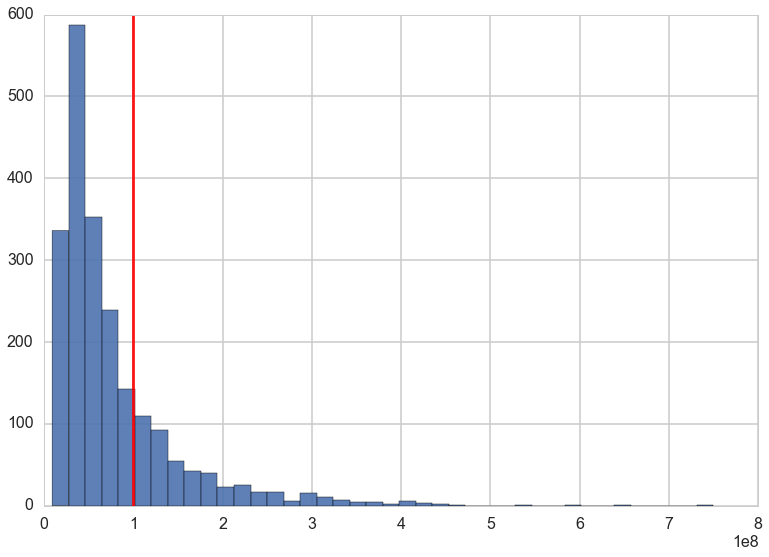

In [962]:
graph_val_avg = plt.hist(dftouse.gross,bins=40,alpha=0.9,label="Blockbuster reviews")
graph_val_avg = plt.axvline(x=100000000, color='red',alpha=0.9,label="Blockbuster mean")






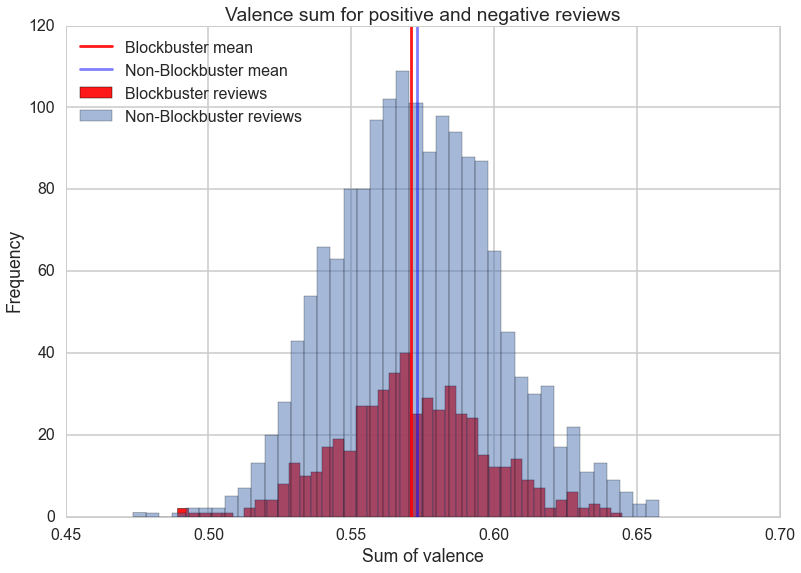

In [958]:
graph_val_avg = plt.hist(dftouse.pct_scorables[dftouse.adj_opening_gross_bin ==1],bins=40,alpha=0.9,label="Blockbuster reviews",color="red")
graph_val_avg = plt.hist(dftouse.pct_scorables[dftouse.adj_opening_gross_bin ==0],bins=40,alpha=0.5,label="Non-Blockbuster reviews")
graph_val_avg = plt.axvline(x=dftouse.pct_scorables[dftouse.adj_opening_gross_bin ==1].mean(), color='red',alpha=0.9,label="Blockbuster mean")
graph_val_avg = plt.axvline(x=dftouse.pct_scorables[dftouse.adj_opening_gross_bin ==0].mean(), color='blue',alpha=0.5,label="Non-Blockbuster mean")

graph_val_avg = plt.title("Valence sum for positive and negative reviews")
graph_val_avg = plt.xlabel("Sum of valence")
graph_val_avg = plt.ylabel("Frequency")
graph_val_avg = plt.legend(loc='upper left')

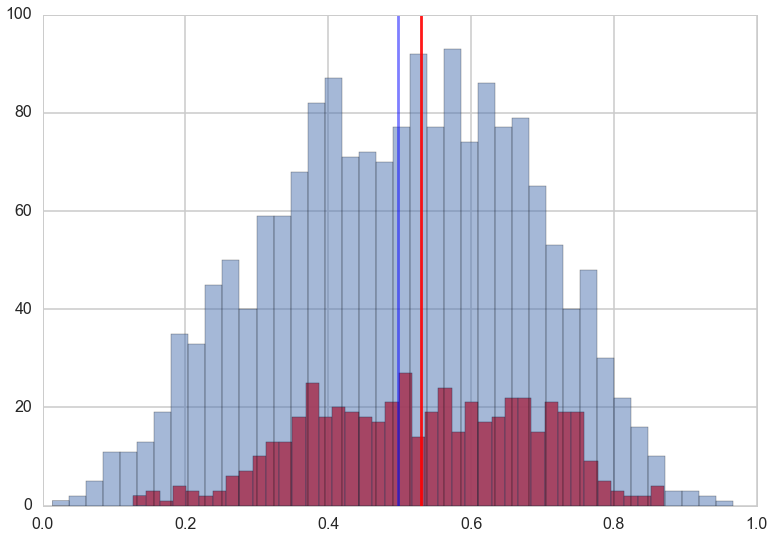

In [1090]:
graph_val_avg = plt.hist(dftouse.valence_avg[dftouse.adj_opening_gross_bin ==1],bins=40,alpha=0.9,label="Blockbuster reviews",color="red")
graph_val_avg = plt.hist(dftouse.valence_avg[dftouse.adj_opening_gross_bin ==0],bins=40,alpha=0.5,label="Non-Blockbuster reviews")
graph_val_avg = plt.axvline(x=dftouse.valence_avg[dftouse.adj_opening_gross_bin ==1].mean(), color='red',alpha=0.9,label="Blockbuster mean")
graph_val_avg = plt.axvline(x=dftouse.valence_avg[dftouse.adj_opening_gross_bin ==0].mean(), color='blue',alpha=0.5,label="Non-Blockbuster mean")



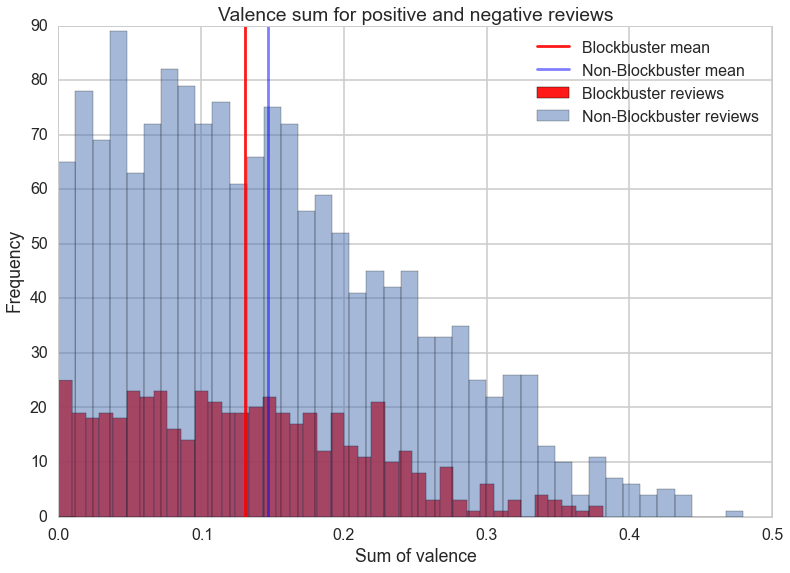

In [996]:
graph_val_avg = plt.hist(dftouse.abs_valence_avg[dftouse.adj_opening_gross_bin ==1],bins=40,alpha=0.9,label="Blockbuster reviews",color="red")
graph_val_avg = plt.hist(dftouse.abs_valence_avg[dftouse.adj_opening_gross_bin ==0],bins=40,alpha=0.5,label="Non-Blockbuster reviews")
graph_val_avg = plt.axvline(x=dftouse.abs_valence_avg[dftouse.adj_opening_gross_bin ==1].mean(), color='red',alpha=0.9,label="Blockbuster mean")
graph_val_avg = plt.axvline(x=dftouse.abs_valence_avg[dftouse.adj_opening_gross_bin ==0].mean(), color='blue',alpha=0.5,label="Non-Blockbuster mean")

graph_val_avg = plt.title("Valence sum for positive and negative reviews")
graph_val_avg = plt.xlabel("Sum of valence")
graph_val_avg = plt.ylabel("Frequency")
graph_val_avg = plt.legend(loc='upper right')

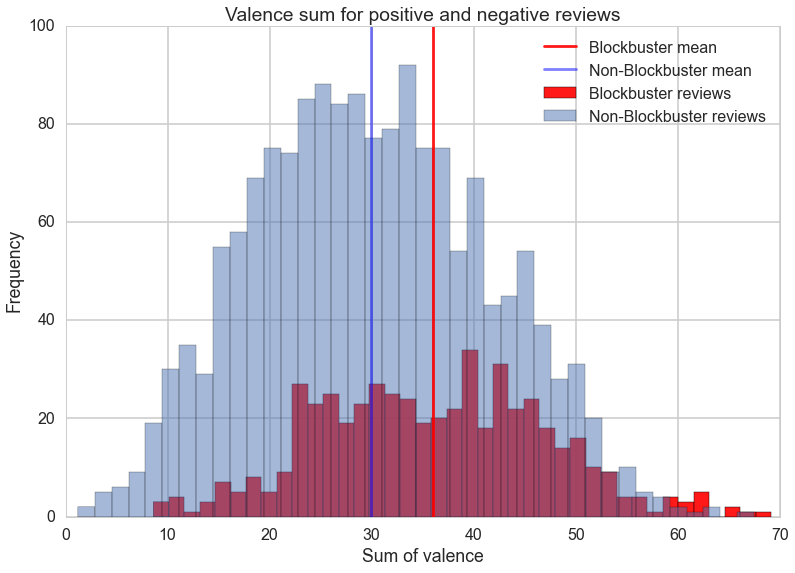

In [955]:
graph_val_avg = plt.hist(dftouse.valence_sum[dftouse.adj_opening_gross_bin ==1],bins=40,alpha=0.9,label="Blockbuster reviews",color="red")
graph_val_avg = plt.hist(dftouse.valence_sum[dftouse.adj_opening_gross_bin ==0],bins=40,alpha=0.5,label="Non-Blockbuster reviews")
graph_val_avg = plt.axvline(x=dftouse.valence_sum[dftouse.adj_opening_gross_bin ==1].mean(), color='red',alpha=0.9,label="Blockbuster mean")
graph_val_avg = plt.axvline(x=dftouse.valence_sum[dftouse.adj_opening_gross_bin ==0].mean(), color='blue',alpha=0.5,label="Non-Blockbuster mean")

graph_val_avg = plt.title("Valence sum for positive and negative reviews")
graph_val_avg = plt.xlabel("Sum of valence")
graph_val_avg = plt.ylabel("Frequency")
graph_val_avg = plt.legend(loc='upper right')

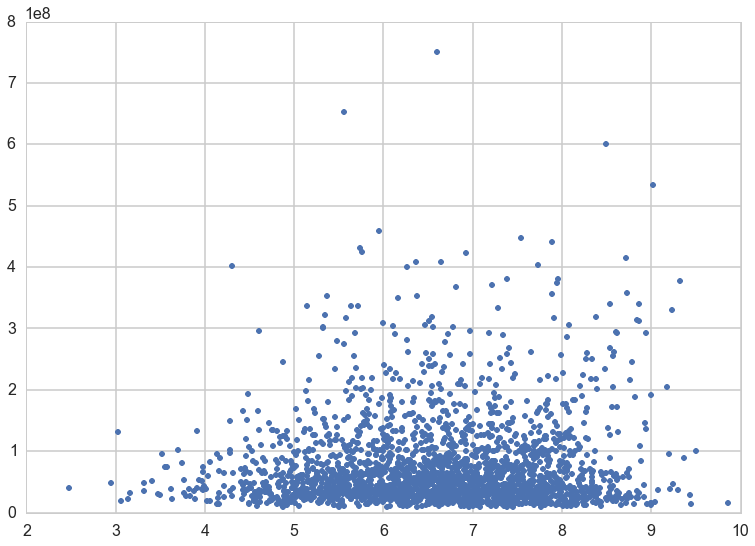

In [1029]:
plt.plot(dftouse.stars,dftouse.gross,'.')

In [1054]:
stars2 = dftouse[dftouse.stars >=1.5][dftouse.stars< 2.5]
# stars2 = stars2.gross[dftouse.stars< 2.5]
# stars2
stars2 = dftouse[dftouse.stars >=1.5][dftouse.stars< 2.5]



In [1058]:
dftouse.head()

stars  valence_avg_var  valence_sum_var      gross  n_scorables  pct_scorables  title  valence_avg  valence_sum  adj_opening_gross  adj_opening_gross_bin  abs_valence_avg
title                                                                                                                                                                                                      
Home Alone                    8.054945         0.085916       928.899501  285761243   124.252747       0.602576     91     0.730695    50.177538           17081997                      1         0.222064
Ghost                         7.936170         0.071250       676.415188  217631306   148.872340       0.576957     94     0.501662    38.295080           12191540                      1         0.006969
Dances with Wolves            8.126316         0.069030       833.506229  184208848   143.621053       0.586112     95     0.535258    41.118159             598257                      1         0.026627
Pretty Woman                  6.565217         0.085160      1691.779142  178406268   139.532609       0.549222     92     0.663993    50.648462           11280591                      1         0.155362
Teenage Mutant Ninja Turtles  4.757895         0.086383       840.313310  135265915   140.126316       0.558065     95     0.445567    33.874786           25398367                      1         0.063063

In [1071]:
stars2 = dftouse[dftouse.stars>=1.5][dftouse.stars<2.5].gross
stars3 = dftouse[dftouse.stars>=2.5]
stars3[stars3.stars<3.5].gross
# [dftouse.stars<3.5].gross
# stars4 = dftouse[dftouse.stars>=3.5][dftouse.stars<4.5].gross
# stars5 = dftouse[dftouse.stars>=4.5][dftouse.stars<5.5].gross

title
Speed 2: Cruise Control              48608066
Mortal Kombat: Annihilation          35927406
That Darn Cat                        18301610
Battlefield Earth                    21471685
Halloween: Resurrection              30354442
Date Movie                           48548426
The Last Airbender                  131772187
Ghost Rider: Spirit of Vengeance     51774002
Scary Movie 5                        32015787
Name: gross, dtype: float64

In [1086]:

stars10

stars  valence_avg_var  valence_sum_var     gross  n_scorables  pct_scorables  title  valence_avg  valence_sum  adj_opening_gross  adj_opening_gross_bin  abs_valence_avg
title                                                                                                                                                                                    
Eve's Bayou  9.858586         0.084754       299.069171  14842388    89.131313        0.49016     99       0.5854    26.152302            3287846                      0         0.076769

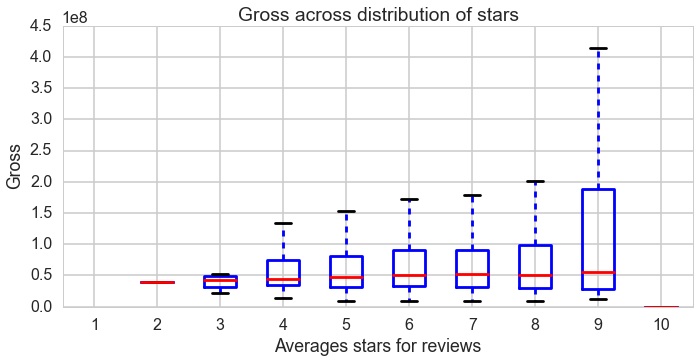

In [1093]:
stars1 = dftouse.gross[dftouse.stars<1.5]
stars2 = dftouse[dftouse.stars >=1.5]
stars2 = stars2.gross[dftouse.stars< 2.5]

stars3 = dftouse[dftouse.stars>=2.5]
stars3=stars3[stars3.stars<3.5].gross

stars4 = dftouse[dftouse.stars>=3.5]
stars4=stars4[stars4.stars<4.5].gross

stars5 = dftouse[dftouse.stars>=4.5]
stars5=stars5[stars5.stars<5.5].gross

stars6 = dftouse[dftouse.stars>=5.5]
stars6=stars6[stars6.stars<6.5].gross

stars7 = dftouse[dftouse.stars>=6.5]
stars7=stars7[stars7.stars<7.5].gross

stars8 = dftouse[dftouse.stars>=7.5]
stars8=stars8[stars8.stars<8.5].gross

stars9 = dftouse[dftouse.stars>=8.5]
stars9=stars9[stars9.stars<9.5].gross

stars10 = dftouse[dftouse.stars>=9.5]

boxplot_data = [stars1,stars2,stars3,stars4,stars5,stars6,stars7,stars8,stars9,stars10]

fig, ax1 = plt.subplots(figsize=(10, 6))
# fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
bp = plt.boxplot(boxplot_data, notch=0, sym='+', vert=1, whis=1.5)

# Hide these grid behind plot objects
ax1.set_ylim(0, 450000000)
ax1.set_axisbelow(True)
ax1.set_title('Gross across distribution of stars')
ax1.set_xlabel('Averages stars for reviews')
ax1.set_ylabel('Gross')

In [1154]:
# stars3bb = dftouse[dftouse.stars>=2.5]
# stars3bb=stars3bb[stars3bb.stars<3.5]
# stars3bb=stars3bb[stars3bb.adj_opening_gross_bin == 1].gross
# stars9bb

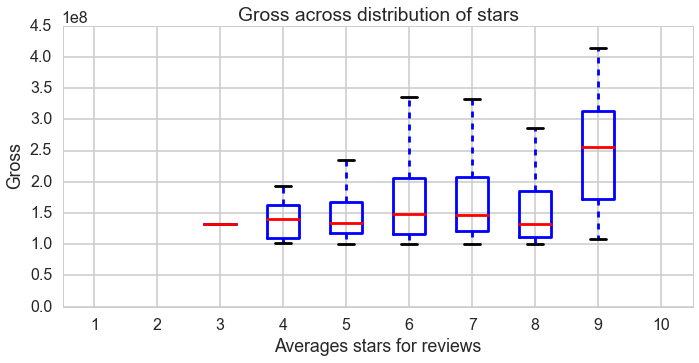

In [1152]:
stars1bb = dftouse.gross[dftouse.stars<1.5]

stars2bb = dftouse[dftouse.stars >=1.5]
stars2bb = stars2bb[dftouse.stars< 2.5]
stars2bb=stars2bb[stars2bb.adj_opening_gross_bin == 1].gross

stars3bb = dftouse[dftouse.stars>=2.5]
stars3bb=stars3bb[stars3bb.stars<3.5]
stars3bb=stars3bb[stars3bb.adj_opening_gross_bin == 1].gross


stars4bb = dftouse[dftouse.stars>=3.5]
stars4bb=stars4bb[stars4bb.stars<4.5]
stars4bb=stars4bb[stars4bb.adj_opening_gross_bin == 1].gross


stars5bb = dftouse[dftouse.stars>=4.5]
stars5bb=stars5bb[stars5bb.stars<5.5]
stars5bb=stars5bb[stars5bb.adj_opening_gross_bin == 1].gross


stars6bb = dftouse[dftouse.stars>=5.5]
stars6bb=stars6bb[stars6bb.stars<6.5]
stars6bb=stars6bb[stars6bb.adj_opening_gross_bin == 1].gross


stars7bb = dftouse[dftouse.stars>=6.5]
stars7bb=stars7bb[stars7bb.stars<7.5]
stars7bb=stars7bb[stars7bb.adj_opening_gross_bin == 1].gross


stars8bb = dftouse[dftouse.stars>=7.5]
stars8bb=stars8bb[stars8bb.stars<8.5]
stars8bb=stars8bb[stars8bb.adj_opening_gross_bin == 1].gross


stars9bb = dftouse[dftouse.stars>=8.5]
stars9bb=stars9bb[stars9bb.stars<9.5]
stars9bb=stars9bb[stars9bb.adj_opening_gross_bin == 1].gross

stars10bb = dftouse[dftouse.stars>=9.5]
stars10bb=stars10bb[stars10bb.adj_opening_gross_bin == 1].gross


stars1nbb = dftouse.gross[dftouse.stars<1.5]

stars2nbb = dftouse[dftouse.stars >=1.5]
stars2nbb = stars2nbb[dftouse.stars< 2.5]
stars2nbb=stars2nbb[stars2nbb.adj_opening_gross_bin == 0].gross

stars3nbb = dftouse[dftouse.stars>=2.5]
stars3nbb=stars3nbb[stars3nbb.stars<3.5]
stars3nbb=stars3nbb[stars3nbb.adj_opening_gross_bin == 0].gross


stars4nbb = dftouse[dftouse.stars>=3.5]
stars4nbb=stars4nbb[stars4nbb.stars<4.5]
stars4nbb=stars4nbb[stars4nbb.adj_opening_gross_bin == 0].gross


stars5nbb = dftouse[dftouse.stars>=4.5]
stars5nbb=stars5nbb[stars5nbb.stars<5.5]
stars5nbb=stars5nbb[stars5nbb.adj_opening_gross_bin == 0].gross


stars6nbb = dftouse[dftouse.stars>=5.5]
stars6nbb=stars6nbb[stars6nbb.stars<6.5]
stars6nbb=stars6nbb[stars6nbb.adj_opening_gross_bin == 0].gross


stars7nbb = dftouse[dftouse.stars>=6.5]
stars7nbb=stars7nbb[stars7nbb.stars<7.5]
stars7nbb=stars7nbb[stars7nbb.adj_opening_gross_bin == 0].gross


stars8nbb = dftouse[dftouse.stars>=7.5]
stars8nbb=stars8nbb[stars8nbb.stars<8.5]
stars8nbb=stars8nbb[stars8nbb.adj_opening_gross_bin == 0].gross


stars9nbb = dftouse[dftouse.stars>=8.5]
stars9nbb=stars9nbb[stars9nbb.stars<9.5]
stars9nbb=stars9nbb[stars9nbb.adj_opening_gross_bin == 0].gross

stars10nbb = dftouse[dftouse.stars>=9.5]
stars10nbb=stars10nbb[stars10nbb.adj_opening_gross_bin == 0].gross


boxplot_data_bb = [stars1bb,stars2bb,stars3bb,stars4bb,stars5bb,stars6bb,stars7bb,stars8bb,stars9bb,stars10bb]
boxplot_data_nbb = [stars1nbb,stars2nbb,stars3nbb,stars4nbb,stars5nbb,stars6nbb,stars7nbb,stars8nbb,stars9nbb,stars10nbb]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp_bb = plt.boxplot(boxplot_data_bb, notch=0, sym='+', vert=1, whis=1.5)
# bp_nbb = plt.boxplot(boxplot_data_nbb, notch=0, sym='+', vert=1, whis=1.5)


# bp_bb = plt.boxplot(boxplot_data_bb, notch=0, sym='+', vert=1, whis=1.5, ax = ax1.ravel()[0])
# bp_nbb =plt.boxplot(boxplot_data_nbb, notch=0, sym='+', vert=1, whis=1.5,ax = ax1.ravel()[1])



# Hide these grid behind plot objects
ax1.set_ylim(0, 450000000)
ax1.set_axisbelow(True)
ax1.set_title('Gross across distribution of stars')
ax1.set_xlabel('Averages stars for reviews')
ax1.set_ylabel('Gross')

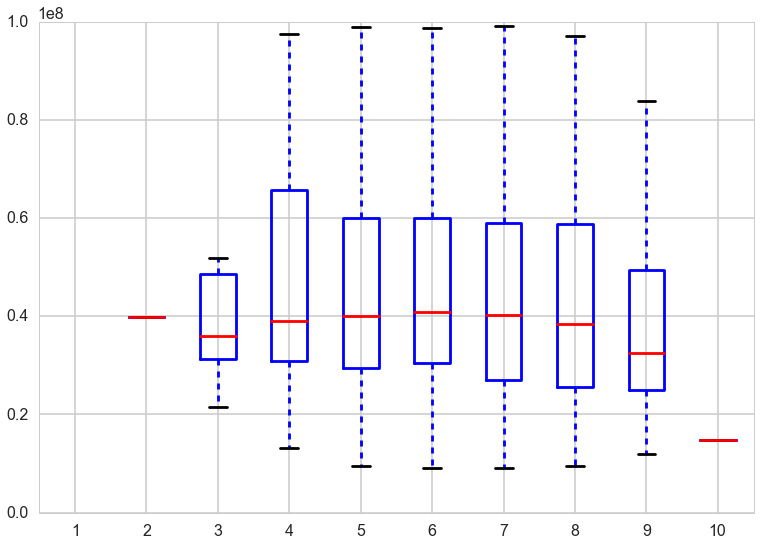

In [1153]:
bp_nbb = plt.boxplot(boxplot_data_nbb, notch=0, sym='+', vert=1, whis=1.5)

In [1200]:
dftouse.head()

year  theaters  opening_theaters     stars  valence_avg_var  valence_sum_var      gross  n_scorables  pct_scorables  title  valence_avg  valence_sum  adj_opening_gross  adj_opening_gross_bin  abs_valence_avg
title                                                                                                                                                                                                                                        
Home Alone                    1990      2173              1202  8.054945         0.085916       928.899501  285761243   124.252747       0.602576     91     0.730695    50.177538           17081997                      1         0.222064
Ghost                         1990      1766              1101  7.936170         0.071250       676.415188  217631306   148.872340       0.576957     94     0.501662    38.295080           12191540                      1         0.006969
Dances with Wolves            1990      1636                14  8.126316         0.069030       833.506229  184208848   143.621053       0.586112     95     0.535258    41.118159             598257                      1         0.026627
Pretty Woman                  1990      1811              1325  6.565217         0.085160      1691.779142  178406268   139.532609       0.549222     92     0.663993    50.648462           11280591                      1         0.155362
Teenage Mutant Ninja Turtles  1990      2377              2006  4.757895         0.086383       840.313310  135265915   140.126316       0.558065     95     0.445567    33.874786           25398367                      1         0.063063

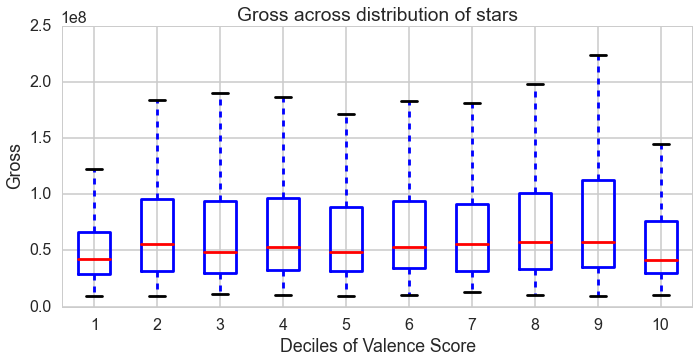

In [1170]:
stars1 = dftouse.gross[dftouse.valence_avg<np.percentile(dftouse.valence_avg, 15)]

stars2 = dftouse[dftouse.valence_avg >=np.percentile(dftouse.valence_avg, 15)]
stars2 = stars2[stars2.valence_avg< np.percentile(dftouse.valence_avg, 25)].gross

stars3 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 25)]
stars3=stars3[stars3.valence_avg<np.percentile(dftouse.valence_avg, 35)].gross

stars4 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 35)]
stars4=stars4[stars4.valence_avg<np.percentile(dftouse.valence_avg, 45)].gross

stars5 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 45)]
stars5=stars5[stars5.valence_avg<np.percentile(dftouse.valence_avg, 55)].gross

stars6 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 55)]
stars6=stars6[stars6.valence_avg<np.percentile(dftouse.valence_avg, 65)].gross

stars7 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 65)]
stars7=stars7[stars7.valence_avg<np.percentile(dftouse.valence_avg, 75)].gross

stars8 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 75)]
stars8=stars8[stars8.valence_avg<np.percentile(dftouse.valence_avg, 85)].gross

stars9 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 85)]
stars9=stars9[stars9.valence_avg<np.percentile(dftouse.valence_avg, 95)].gross

stars10 = dftouse[dftouse.valence_avg>=np.percentile(dftouse.valence_avg, 95)].gross

boxplot_data = [stars1,stars2,stars3,stars4,stars5,stars6,stars7,stars8,stars9,stars10]

fig, ax1 = plt.subplots(figsize=(10, 6))
# fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
bp = plt.boxplot(boxplot_data, notch=0, sym='+', vert=1, whis=1.5)

# Hide these grid behind plot objects
ax1.set_ylim(0, 250000000)
ax1.set_axisbelow(True)
ax1.set_title('Gross across distribution of stars')
ax1.set_xlabel('Deciles of Valence Score')
ax1.set_ylabel('Gross')

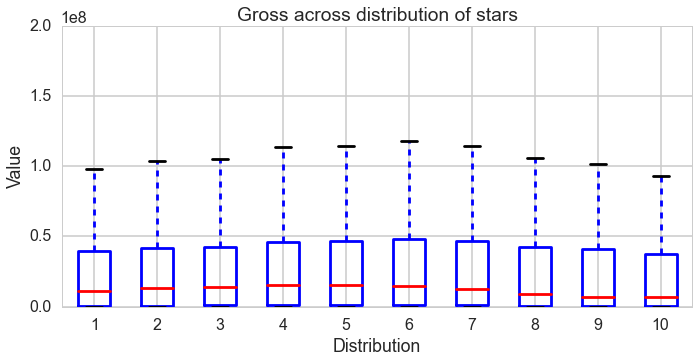

In [1027]:
stars1 = dftouse2.gross[dftouse2.stars==1]
stars2 = dftouse2.gross[dftouse2.stars==2]
stars3 = dftouse2.gross[dftouse2.stars==3]
stars4 = dftouse2.gross[dftouse2.stars==4]
stars5 = dftouse2.gross[dftouse2.stars==5]
stars6 = dftouse2.gross[dftouse2.stars==6]
stars7 = dftouse2.gross[dftouse2.stars==7]
stars8 = dftouse2.gross[dftouse2.stars==8]
stars9 = dftouse2.gross[dftouse2.stars==9]
stars10 = dftouse2.gross[dftouse2.stars==10]
boxplot_data = [stars1,stars2,stars3,stars4,stars5,stars6,stars7,stars8,stars9,stars10]

fig, ax1 = plt.subplots(figsize=(10, 6))
# fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
bp = plt.boxplot(boxplot_data, notch=0, sym='+', vert=1, whis=1.5)

# Hide these grid behind plot objects
ax1.set_ylim(0, 200000000)
ax1.set_axisbelow(True)
ax1.set_title('Gross across distribution of stars')
ax1.set_xlabel('Distribution')
ax1.set_ylabel('Value')

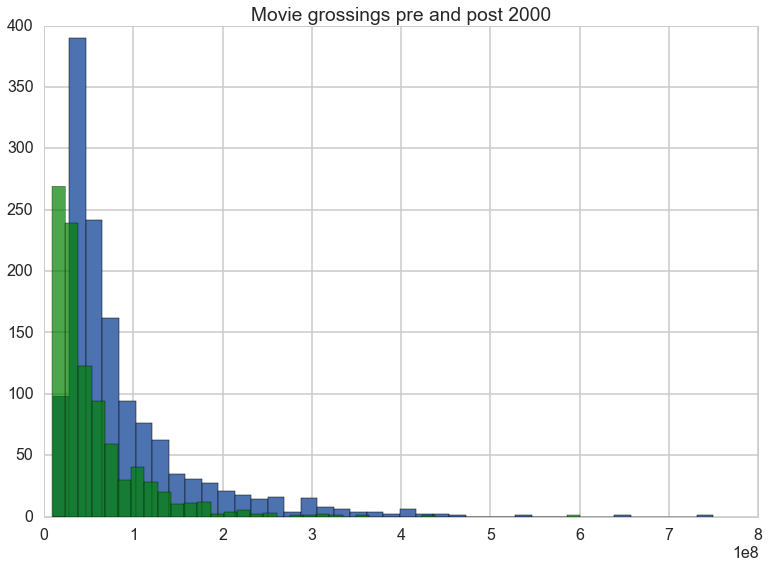

In [1195]:
decadesplot = plt.hist(dftouse[dftouse.year>2000].gross,bins=40);
decadesplot = plt.hist(dftouse[dftouse.year<=2000].gross,bins=40,color='g',alpha=0.7);
decadesplot = plt.title('Movie grossings pre and post 2000')

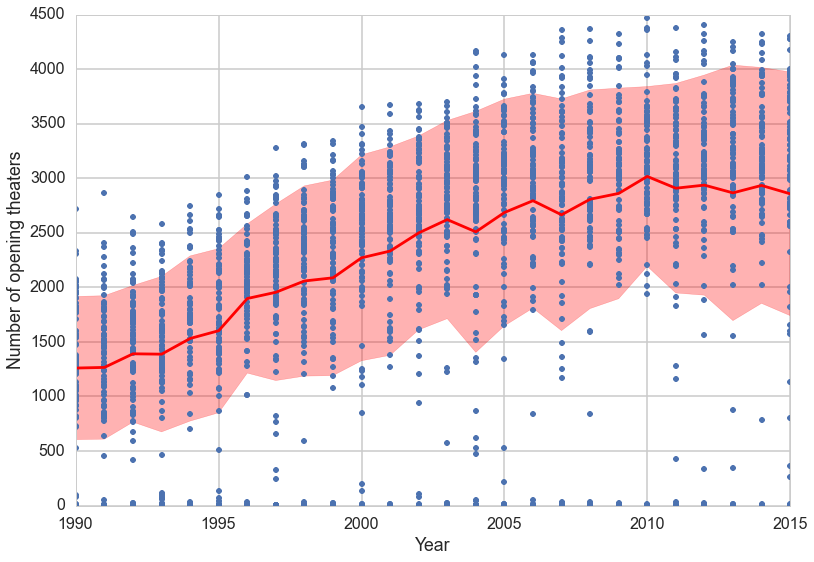

In [1255]:
year_theaters = dftouse.groupby('year')
mean_year_theaters = year_theaters['opening_theaters'].mean()
std_year_theaters=year_theaters['opening_theaters'].std()
# theaterinfo={'meanseries': year_theaters['opening_theaters'].mean(), 
#                   'stdseries': year_theaters['opening_theaters'].std()}

# mean_year_theaters
decadesplot = plt.plot(dftouse.year,dftouse.opening_theaters,'.')
decadesplot=plt.plot(mean_year_theaters.index,mean_year_theaters, color='r')
decadesplot= plt.fill_between(std_year_theaters.index,mean_year_theaters+std_year_theaters,mean_year_theaters-std_year_theaters,color='r',alpha=0.3)
decadesplot= plt.xlabel("Year")
decadesplot= plt.ylabel("Number of opening theaters")
decadesplot= plt.title("Number of opening theaters")



# stars_val_avg = ols('year ~ opening_theaters',dftouse).fit()
# stars_val_avg.summary()
# sns.regplot(y="opening_theaters", x="year", data=dftouse)


# plt.hist(dftouse[dftouse.year>2000].theatre,bins=40);
# decadesplot = plt.hist(dftouse[dftouse.year<=2000].gross,bins=40,color='g',alpha=0.7);
# decadesplot = plt.title('Movie grossings pre and post 2000')

In [1221]:
dftouse[dftouse['opening_theaters']<=5].shape

(92, 15)

In [ ]:
decadesplot = plt.hist(dftouse[dftouse.year>2000].gross,bins=40);
decadesplot = plt.hist(dftouse[dftouse.year<=2000].gross,bins=40,color='g',alpha=0.7);
decadesplot = plt.title('Movie grossings pre and post 2000')

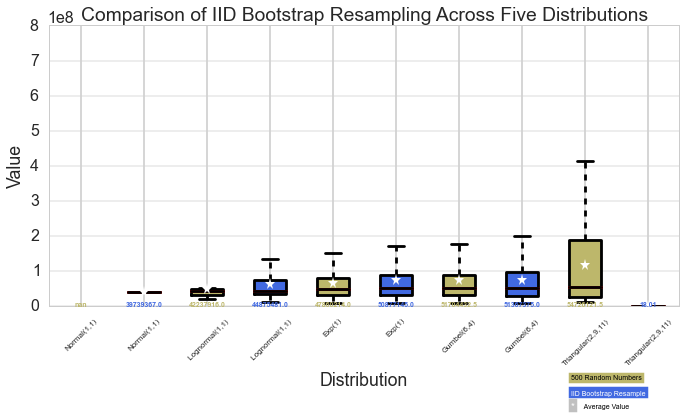

In [1087]:
"""
Thanks Josh Hemann for the example
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# Generate some data from five different probability distributions,
# each with different characteristics. We want to play with how an IID
# bootstrap resample of the data preserves the distributional
# properties of the original sample, and a boxplot is one visual tool
# to make this assessment
numDists = 5
randomDists = ['Normal(1,1)', ' Lognormal(1,1)', 'Exp(1)', 'Gumbel(6,4)',
               'Triangular(2,9,11)']
N = 500
norm = np.random.normal(1, 1, N)
logn = np.random.lognormal(1, 1, N)
expo = np.random.exponential(1, N)
gumb = np.random.gumbel(6, 4, N)
tria = np.random.triangular(2, 9, 11, N)

# Generate some random indices that we'll use to resample the original data
# arrays. For code brevity, just use the same random indices for each array
bootstrapIndices = np.random.random_integers(0, N - 1, N)
normBoot = norm[bootstrapIndices]
expoBoot = expo[bootstrapIndices]
gumbBoot = gumb[bootstrapIndices]
lognBoot = logn[bootstrapIndices]
triaBoot = tria[bootstrapIndices]

data = [stars1,stars2,stars3,stars4,stars5,stars6,stars7,stars8,stars9,stars10]

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.canvas.set_window_title('A Boxplot Example')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

bp = plt.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
plt.setp(bp['boxes'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['fliers'], color='red', marker='+')

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

# Hide these grid behind plot objects
ax1.set_axisbelow(True)
ax1.set_title('Comparison of IID Bootstrap Resampling Across Five Distributions')
ax1.set_xlabel('Distribution')
ax1.set_ylabel('Value')

# Now fill the boxes with desired colors
boxColors = ['darkkhaki', 'royalblue']
numBoxes = numDists*2
medians = list(range(numBoxes))
for i in range(numBoxes):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='*', markeredgecolor='k')

# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
# top = 40
# bottom = -5
# ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=np.repeat(randomDists, 2))
plt.setp(xtickNames, rotation=45, fontsize=8)

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-small', weight=weights[k],
             color=boxColors[k])

# Finally, add a basic legend
plt.figtext(0.80, 0.08, str(N) + ' Random Numbers',
            backgroundcolor=boxColors[0], color='black', weight='roman',
            size='x-small')
plt.figtext(0.80, 0.045, 'IID Bootstrap Resample',
            backgroundcolor=boxColors[1],
            color='white', weight='roman', size='x-small')
plt.figtext(0.80, 0.015, '*', color='white', backgroundcolor='silver',
            weight='roman', size='medium')
plt.figtext(0.815, 0.013, ' Average Value', color='black', weight='roman',
            size='x-small')

plt.show()

In [ ]:
graph_val_avg = plt.hist(dftouse.valence_avg[dftouse.adj_opening_gross_bin ==1],bins=40,alpha=0.9,label="Positive reviews",color="red")
graph_val_avg = plt.hist(dftouse.valence_avg[dftouse.adj_opening_gross_bin ==0],bins=40,alpha=0.5,label="Negative reviews")
graph_val_avg = plt.title("Valence sum for positive and negative reviews")
graph_val_avg = plt.xlabel("Sum of valence")
graph_val_avg = plt.ylabel("Frequency")
graph_val_avg = plt.legend(loc='upper right')

/Users/jasondong/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


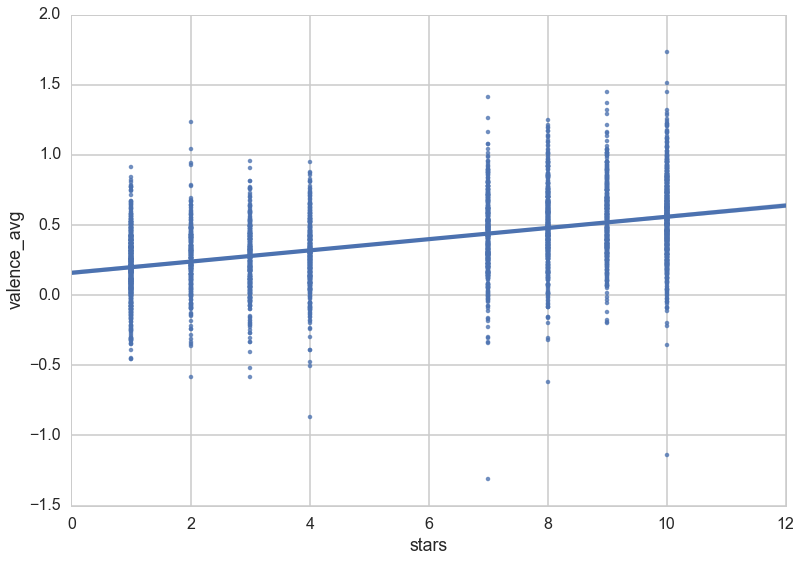

In [22]:
stars_val_avg = ols('stars ~ valence_avg',valence_df).fit()
stars_val_avg.summary()
sns.regplot(y="valence_avg", x="stars", data=valence_df)
# plt.plot(valence_df.stars,valence_df.valence_avg,'.',alpha=0.6)

Yes it does, to some extent. The explanatory power is not high though...

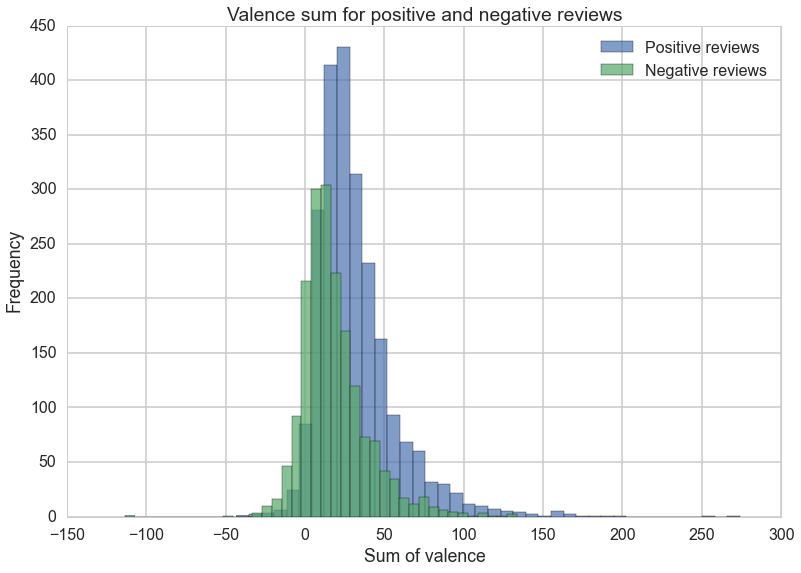

In [23]:
graph_val_avg = plt.hist(valence_df.valence_sum[valence_df.stars >=7],bins=40,alpha=0.7,label="Positive reviews")
graph_val_avg = plt.hist(valence_df.valence_sum[valence_df.stars <=4],bins=40,alpha=0.7,label="Negative reviews")
graph_val_avg = plt.title("Valence sum for positive and negative reviews")
graph_val_avg = plt.xlabel("Sum of valence")
graph_val_avg = plt.ylabel("Frequency")
graph_val_avg = plt.legend(loc='upper right')

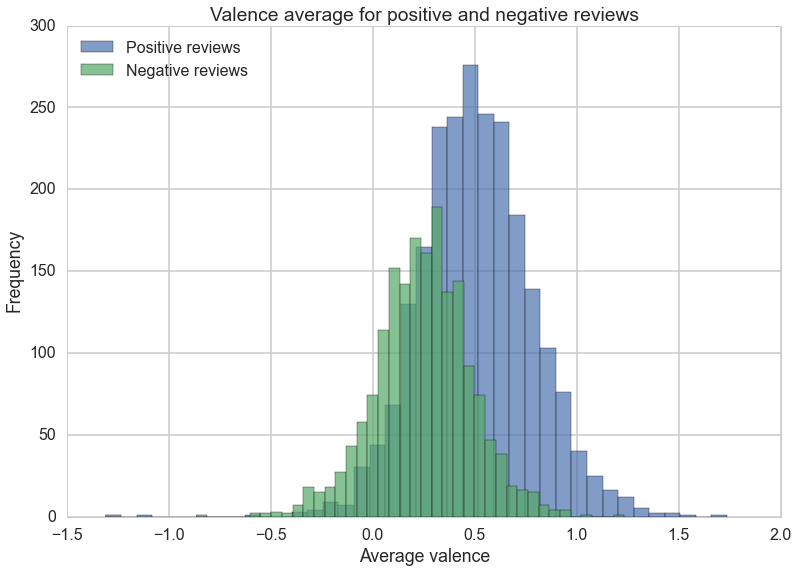

In [24]:
graph_val_avg = plt.hist(valence_df.valence_avg[valence_df.stars >=7],bins=40,alpha=0.7,label="Positive reviews")
graph_val_avg = plt.hist(valence_df.valence_avg[valence_df.stars <=4],bins=40,alpha=0.7,label="Negative reviews")
graph_val_avg = plt.title("Valence average for positive and negative reviews")
graph_val_avg = plt.xlabel("Average valence")
graph_val_avg = plt.ylabel("Frequency")
graph23 = plt.legend(loc='upper left')

Now we'll import allMoives_new.json. Remember that we still need to convert some of the columns into the datetime type so we'll do that afterwards. 

In [25]:
with open("allMovies.json", "r") as fd:
    bom_df = json.load(fd)
    bom_df = pd.DataFrame(bom_df)

In [26]:
bom_df[2572:2577]

close_date close_day close_month close_year     gross            open_date open_day open_month open_year  opening_gross  opening_theaters  ranking                                 title  total_theaters  year
2572  {u'$date': 1446076800000}        29          10       2015  27740955  1440115200000000000       21          8      2015       10542116              2766       73                            Sinister 2            2799  2015
2573  {u'$date': 1448496000000}        26          11       2015  27288872  1440547200000000000       26          8      2015        8111264              3355       74                             No Escape            3415  2015
2574                       None         0           0       2016  27001705  1445558400000000000       23         10      2015       10812861              3082       75                 The Last Witch Hunter            3082  2015
2575                       None         0           0       2016  26822144  1438905600000000000        7          8      2015        6610961              1603       76                   Ricki and the Flash            2064  2015
2576  {u'$date': 1426723200000}        19           3       2015  26501323  1420156800000000000        2          1      2015       15027415              2602       77  The Woman in Black 2: Angel of Death            2602  2015

In [27]:
# making close_date and open_date by concatenating the year, month and day
import datetime
close_date = []
for index, row in bom_df.iterrows():
    if row.close_day != '0':
        close_date.append(datetime.datetime(int(row.close_year), int(row.close_month), int(row.close_day)))
    else: 
        close_date.append(None)
bom_df['close_date'] = close_date

bom_df['open_date']=bom_df.open_year + '-' + bom_df.open_month + '-' + bom_df.open_day
bom_df['open_date']=bom_df['open_date'].apply(pd.datetools.parse)

# dropping unnecessary columns
bom_df = bom_df.drop('close_day', 1)
bom_df = bom_df.drop('close_month', 1)
bom_df = bom_df.drop('open_day', 1)
bom_df = bom_df.drop('open_month', 1)

Great! Let's take a look at all the dataframes we've created

In [28]:
bom_df

close_date close_year      gross  open_date open_year  opening_gross  opening_theaters  ranking                                     title  total_theaters  year
0                    None       1991  285761243 1990-11-16      1990       17081997              1202        1                                Home Alone            2173  1990
1                    None       1991  217631306 1990-07-13      1990       12191540              1101        2                                     Ghost            1766  1990
2                    None       1991  184208848 1990-11-09      1990         598257                14        3                        Dances with Wolves            1636  1990
3                    None       1991  178406268 1990-03-23      1990       11280591              1325        4                              Pretty Woman            1811  1990
4                    None       1991  135265915 1990-03-30      1990       25398367              2006        5              Teenage Mutant Ninja Turtles            2377  1990
5                    None       1991  122012643 1990-03-02      1990       17161835              1225        6                  The Hunt for Red October            1817  1990
6                    None       1991  119394840 1990-06-01      1990       25533700              2060        7                              Total Recall            2131  1990
7                    None       1991  117540947 1990-07-06      1990       21744661              2507        8                    Die Hard 2: Die Harder            2507  1990
8                    None       1991  103738726 1990-06-15      1990       22543911              2332        9                                Dick Tracy            2332  1990
9                    None       1991   91457688 1990-12-22      1990        7918560              1833       10                          Kindergarten Cop            1937  1990
10                   None       1991   87727583 1990-05-25      1990       19089645              2019       11               Back to the Future Part III            2070  1990
11                   None       1991   86303188 1990-07-27      1990       11718981              1349       12                         Presumed Innocent            1451  1990
12                   None       1991   82670733 1990-06-29      1990       15490445              2307       13                           Days of Thunder            2307  1990
13                   None       1991   80818974 1990-06-08      1990       19475559              2721       14                           Another 48 HRS.            2721  1990
14                   None       1991   71609321 1990-11-21      1990       13774642              1281       15               Three Men and a Little Lady            1614  1990
15                   None       1991   70978012 1990-05-18      1990       15338160              1944       16                            Bird on a Wire            2008  1990
16                   None       1991   66666062 1990-12-25      1990       19558558              1901       17                    The Godfather Part III            1922  1990
17                   None       1991   61489265 1990-08-10      1990       10034685              1319       18                                Flatliners            1483  1990
18                   None       1991   61276872 1990-11-30      1990       10076834              1244       19                                    Misery            1370  1990
19                   None       1991   56362352 1990-12-07      1990         159622                 2       20                       Edward Scissorhands            1372  1990
20                   None       1991   53470891 1990-07-27      1990       10026900              1714       21                             Problem Child            1769  1990
21                   None       1991   53208180 1990-07-20      1990        8045760              1479       22                             Arachnophobia            2

Now, we want to make a new dataframe `flattened_df` that we can use to run our regressions on. This dataframe will include all the columns in `movie_df` and the extra columns
* number of reviews for the movie in IMDB_df
* average stars from the reviews
* overall ranking

In [29]:
# set index to title
indexed_df = bom_df.set_index("title")

In [30]:
# use groupby to get the review_count, star_avg, valence_avg, valence_sum, pct_scorables, n_scorables
gold = valence_df.groupby("movie_name")
n_scorables = gold.n_scorables.mean()
pct_scorables = gold.pct_scorables.mean()
review_count = gold.movie_name.count()
star_avg = gold.stars.mean()
positive = gold.positive.mean()
valence_avg = gold.valence_avg.mean()
valence_sum = gold.valence_sum.mean()

In [31]:
# concatenate the two dfs into our final dataframe flattened_df
flattened_df = pd.concat([indexed_df, review_count], axis=1, join_axes=[indexed_df.index])
flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)
flattened_df = pd.concat([flattened_df, star_avg], axis=1, join_axes=[indexed_df.index])
flattened_df.rename(columns={'stars': 'star_avg'}, inplace=True)
flattened_df = pd.concat([flattened_df, positive], axis=1, join_axes=[indexed_df.index])

flattened_df = pd.concat([flattened_df, valence_avg], axis=1, join_axes=[indexed_df.index])
# flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)
flattened_df = pd.concat([flattened_df, valence_sum], axis=1, join_axes=[indexed_df.index])
# flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)

flattened_df = pd.concat([flattened_df, n_scorables], axis=1, join_axes=[indexed_df.index])

flattened_df = pd.concat([flattened_df, pct_scorables], axis=1, join_axes=[indexed_df.index])


# flattened_df.rename(columns={'absolute_stars': 'abs_star_avg'}, inplace=True)

In [32]:
flattened_df.head()

close_date close_year      gross  open_date open_year  opening_gross  opening_theaters  ranking  total_theaters  year  review_count  star_avg  positive  valence_avg  valence_sum  n_scorables  pct_scorables
title                                                                                                                                                                                                                                     
Home Alone                         None       1991  285761243 1990-11-16      1990       17081997              1202        1            2173  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN
Ghost                              None       1991  217631306 1990-07-13      1990       12191540              1101        2            1766  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN
Dances with Wolves                 None       1991  184208848 1990-11-09      1990         598257                14        3            1636  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN
Pretty Woman                       None       1991  178406268 1990-03-23      1990       11280591              1325        4            1811  1990             2         1         0     0.407409    84.055626          338       0.613324
Teenage Mutant Ninja Turtles       None       1991  135265915 1990-03-30      1990       25398367              2006        5            2377  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN

In [33]:
valence_df['abs_valence_avg'] = np.abs(valence_df['valence_avg']-np.mean(flattened_df['valence_avg']))
abs_valence_avg = gold.abs_valence_avg.mean()
flattened_df = pd.concat([flattened_df, abs_valence_avg], axis=1, join_axes=[indexed_df.index])

Let's take a look at what our dataframe looks like now!

In [34]:
flattened_df.head()

close_date close_year      gross  open_date open_year  opening_gross  opening_theaters  ranking  total_theaters  year  review_count  star_avg  positive  valence_avg  valence_sum  n_scorables  pct_scorables  abs_valence_avg
title                                                                                                                                                                                                                                                      
Home Alone                         None       1991  285761243 1990-11-16      1990       17081997              1202        1            2173  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN              NaN
Ghost                              None       1991  217631306 1990-07-13      1990       12191540              1101        2            1766  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN              NaN
Dances with Wolves                 None       1991  184208848 1990-11-09      1990         598257                14        3            1636  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN              NaN
Pretty Woman                       None       1991  178406268 1990-03-23      1990       11280591              1325        4            1811  1990             2         1         0     0.407409    84.055626          338       0.613324         0.129283
Teenage Mutant Ninja Turtles       None       1991  135265915 1990-03-30      1990       25398367              2006        5            2377  1990           NaN       NaN       NaN          NaN          NaN          NaN            NaN              NaN

In [35]:
# Take only those movies that appear in the IMDB data set, i.e. those that have a review count
flattened_df = flattened_df[~flattened_df['review_count'].map(np.isnan)]
# Let's see how many fo those we have
flattened_df.shape

(334, 18)

In [36]:
flattened_df.head()

close_date close_year      gross  open_date open_year  opening_gross  opening_theaters  ranking  total_theaters  year  review_count  star_avg  positive  valence_avg  valence_sum  n_scorables  pct_scorables  abs_valence_avg
title                                                                                                                                                                                                                                          
Pretty Woman           None       1991  178406268 1990-03-23      1990       11280591              1325        4            1811  1990             2  1.000000       0.0     0.407409    84.055626   338.000000       0.613324         0.129283
Dick Tracy             None       1991  103738726 1990-06-15      1990       22543911              2332        9            2332  1990            24  8.875000       1.0     0.619329    46.075866   142.750000       0.580769         0.294604
Flatliners             None       1991   61489265 1990-08-10      1990       10034685              1319       18            1483  1990            30  6.966667       0.8     0.341229    27.310654   145.866667       0.616311         0.164876
Problem Child          None       1991   53470891 1990-07-27      1990       10026900              1714       21            1769  1990             8  2.500000       0.0     0.181693    15.963458   120.000000       0.607353         0.192622
Marked for Death       None       1991   46044396 1990-10-05      1990       11790047              1968       27            1974  1990             3  4.000000       0.0     0.052945    10.623149   376.000000       0.564525         0.277000

In [37]:
inflation = pd.read_csv("inf.csv")

In [38]:
years_90 = range(1990,2015)
infdict = {}

infindex = 0
infvalue = 1

testlist = []
for row in inflation.values:
    currentval = 1 + (row[1]/100)
    cuminf = infvalue*currentval
    infdict[years_90[infindex]] = cuminf
    infindex += 1
    infvalue = cuminf
    testlist.append(cuminf)

inframe = pd.DataFrame(data=testlist, index=range(1990,2015))

In [39]:
infdict

{1990: 1.0539795644,
 1991: 1.098615219150804,
 1992: 1.1318902930939463,
 1993: 1.1652998117775315,
 1994: 1.1956843237413164,
 1995: 1.229228287177842,
 1996: 1.2652594783591868,
 1997: 1.2948373218617284,
 1998: 1.3149368109750392,
 1999: 1.3437079860225376,
 2000: 1.3890830868495474,
 2001: 1.4283409518690031,
 2002: 1.4509948911070383,
 2003: 1.4839338531885458,
 2004: 1.5236622748059583,
 2005: 1.5753562785628925,
 2006: 1.626176391500925,
 2007: 1.6725658779300527,
 2008: 1.7367773595171863,
 2009: 1.7306023124666896,
 2010: 1.7589849421993997,
 2011: 1.814513310047201,
 2012: 1.852061710150393,
 2013: 1.8791913148899477,
 2014: 1.909675988181881}

In [40]:
newgross, newopengross = [], []
for gross, opengross, openyr in zip(flattened_df.gross, flattened_df.opening_gross, flattened_df.open_year):
    newgross.append(infdict[int(openyr)]*gross)
    newopengross.append(infdict[int(openyr)]*opengross)

In [134]:
dftouse0 = flattened_df
dftouse0['adj_gross'] = newgross
dftouse0['adj_opening_gross'] = newopengross

In [136]:
# creating binary variables of adjusted grossing for classifications
dftouse0['adj_gross_bin'] = 1*(dftouse0.adj_gross>np.mean(dftouse0.adj_gross))
dftouse0['adj_opening_gross_bin'] = 1*(dftouse0.adj_opening_gross>np.mean(dftouse0.adj_opening_gross))

In [137]:
dftouse0.head()

close_date close_year      gross  open_date open_year  opening_gross  opening_theaters  ranking  total_theaters  year  review_count  star_avg  positive  valence_avg  valence_sum  n_scorables  pct_scorables  abs_valence_avg     adj_gross  adj_opening_gross  adj_gross_bin  adj_opening_gross_bin
title                                                                                                                                                                                                                                                                                                                 
Pretty Woman           None       1991  178406268 1990-03-23      1990       11280591              1325        4            1811  1990             2  1.000000       0.0     0.407409    84.055626   338.000000       0.613324         0.129283  1.880366e+08    11889512.388355              1                      0
Dick Tracy             None       1991  103738726 1990-06-15      1990       22543911              2332        9            2332  1990            24  8.875000       1.0     0.619329    46.075866   142.750000       0.580769         0.294604  1.093385e+08    23760821.495652              1                      1
Flatliners             None       1991   61489265 1990-08-10      1990       10034685              1319       18            1483  1990            30  6.966667       0.8     0.341229    27.310654   145.866667       0.616311         0.164876  6.480843e+07    10576352.925191              0                      0
Problem Child          None       1991   53470891 1990-07-27      1990       10026900              1714       21            1769  1990             8  2.500000       0.0     0.181693    15.963458   120.000000       0.607353         0.192622  5.635723e+07    10568147.694282              0                      0
Marked for Death       None       1991   46044396 1990-10-05      1990       11790047              1968       27            1974  1990             3  4.000000       0.0     0.052945    10.623149   376.000000       0.564525         0.277000  4.852985e+07    12426468.601316              0                      0

Now that we have adjusted for inflation, we can remove the previous gross and all columns pertaining to date (except perhaps `year`, since it's interesting).

In [139]:
keep = ['ranking','total_theaters', 'year', 'review_count', 'star_avg','positive','valence_avg','valence_sum',
        'n_scorables','pct_scorables','abs_valence_avg','adj_gross', 'adj_opening_gross', 'adj_gross_bin','adj_opening_gross_bin']
dftouse0 = dftouse0[keep]

In [140]:
# Let's see the new data frame
dftouse0.head()

ranking  total_theaters  year  review_count  star_avg  positive  valence_avg  valence_sum  n_scorables  pct_scorables  abs_valence_avg     adj_gross  adj_opening_gross  adj_gross_bin  adj_opening_gross_bin
title                                                                                                                                                                                                                          
Pretty Woman            4            1811  1990             2  1.000000       0.0     0.407409    84.055626   338.000000       0.613324         0.129283  1.880366e+08    11889512.388355              1                      0
Dick Tracy              9            2332  1990            24  8.875000       1.0     0.619329    46.075866   142.750000       0.580769         0.294604  1.093385e+08    23760821.495652              1                      1
Flatliners             18            1483  1990            30  6.966667       0.8     0.341229    27.310654   145.866667       0.616311         0.164876  6.480843e+07    10576352.925191              0                      0
Problem Child          21            1769  1990             8  2.500000       0.0     0.181693    15.963458   120.000000       0.607353         0.192622  5.635723e+07    10568147.694282              0                      0
Marked for Death       27            1974  1990             3  4.000000       0.0     0.052945    10.623149   376.000000       0.564525         0.277000  4.852985e+07    12426468.601316              0                      0

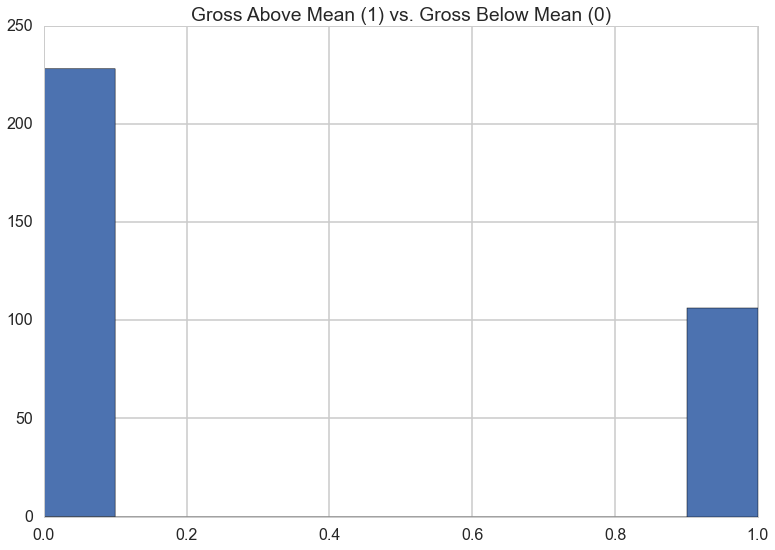

In [141]:
plt.hist(dftouse0.adj_gross_bin)
plt.title("Gross Above Mean (1) vs. Gross Below Mean (0)")

In [47]:
# Let's save
fp = open("dftouse.json","w")
json.dump(dftouse.to_dict(), fp)
fp.close()

- useful to consider polarizing reviews actually predict the box office performance
- measures of dispersion on the sentiment analysis
- different types of distributions you have in a given review
- how frequently are certain words used
- average length of words
- average document lengths
- ratio between high valence words and low valence words
- we can do different sentiment scores based on different sentiment dictionaries
- could use a BOW model (have the corpus of words in the reviews) & shrink down for regularization 

- We can adopt the hypothesis that stars predict box office gross
- Or hypothesis that evry polarized responses predict box office gross
- okay to have dud hypothesis

- Graded on the effort we put in - low unimpressive results should not be equated with not having much work to do. We can make up for it via lit reviews or extra research. 

### Analysis

In [48]:
# Reopen dftouse
with open("dftouse.json", "r") as fp:
    dftouse_dict = json.load(fp)
dftouse = pd.DataFrame(dftouse_dict)

We have chosen to only use opening grossing of movies as our y-variable. This is because the time for which the movie is open is standardized. We considered using (total grossing)/(total time in theaters) as the y-variable, but this was not feasible because we do not have a closing date for every movie and therefore could not calculate the total time in theaters fo every review.

Let's remove outliers from the dataset, so that we can more easily see trends. An outlier in column valence_avg is defined as a point that it more than 3 standard deviations away from the mean.

In [50]:
def is_not_outlier(num, avg, sd, m = 3.):
    return np.absolute(num-avg) < m*sd

In [51]:
v_avg_avg = np.mean(dftouse.valence_avg)
v_avg_sd = np.std(dftouse.valence_avg)
mask = [is_not_outlier(num, v_avg_avg, v_avg_sd) for num in dftouse.valence_avg]

Let's see how many outliers we removed.

In [52]:
len(dftouse.valence_avg) - sum(mask)

2

In [53]:
dftouse = dftouse[mask]

Now let's make scatter plots for each review, of opening gross values against average valence, sum valence, and polarity (absolute valence_avg).

/Users/jasondong/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


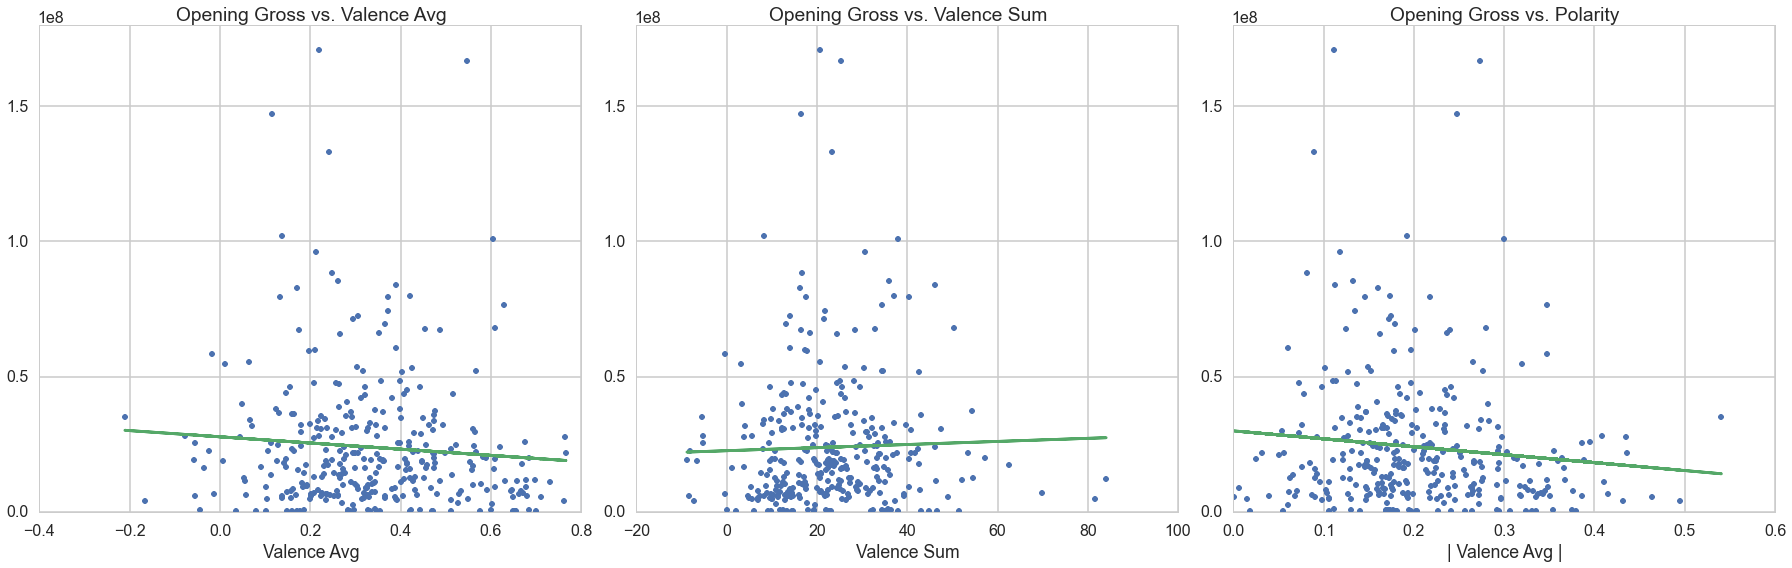

In [54]:
# First, let's make scatter plots of opening gross numbers against valence_avg
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8),tight_layout = True)
titles = ["Opening Gross vs. Valence Avg", "Opening Gross vs. Valence Sum", "Opening Gross vs. Polarity"]
xlabels = ["Valence Avg", "Valence Sum", "| Valence Avg |"]
x = [dftouse.valence_avg, dftouse.valence_sum, dftouse.abs_valence_avg]
for (ax, title, xlabel, x) in zip(axes.ravel(), titles, xlabels, x):
    m, b = np.polyfit(x, dftouse.adj_opening_gross, 1)
#     ax.plot(x, m*x + b, '-')
    ax.plot(x, dftouse.adj_opening_gross, '.',x, m*x + b, '-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylim(-1000, 1.8*1e8)

The above scatterplots seem to show that there is little correlation between opening gross and all three predictors.

However, we foresee a limitation to our analysis. The reviews dataset we have was constructed by taking the most polarizing reviews that did not represent the realistic viewership response. For example, very successful movies that have bad reviews might be predicted as lowly grossing because they have a few poor reviews and it is in our dataset. To curb this problem, we are going to divide our dataset into movies that that received poor reviews and movies receivin good reviews. This is defined as the reviewer giving less than 4 stars and the reviewer giving more than 7 stars. We then conduct our regression analysis for each of these sub-datasets. Our hypothesis is that good, higher grossing movies that received poor reviews will receive less poorer reviews on average. In contrast, the good movies that received good reviews should receive higher reviews on average. We create these separate datasets below.

In [55]:
dftouse_small = dftouse[dftouse['valence_avg'] <= np.mean(dftouse['valence_avg'])]
dftouse_large = dftouse[dftouse['valence_avg'] >= np.mean(dftouse['valence_avg'])]

In [56]:
# And now, regressions
reg_list = []

og_val_avg = ols('adj_opening_gross ~ valence_avg',dftouse).fit()
og_val_avg_small = ols('adj_opening_gross ~ valence_avg',dftouse_small).fit()
og_val_avg_large = ols('adj_opening_gross ~ valence_avg',dftouse_large).fit()
og_abs_val_avg_large = ols('adj_opening_gross ~ abs_valence_avg',dftouse).fit()

og_val_sum = ols('adj_opening_gross ~ valence_sum',dftouse).fit()
og_val_sum_small = ols('adj_opening_gross ~ valence_sum',dftouse_small).fit()
og_val_sum_large = ols('adj_opening_gross ~ valence_sum',dftouse_large).fit()

reg_list.append(og_val_avg)
reg_list.append(og_val_avg)
reg_list.append(og_val_avg_small)
reg_list.append(og_val_avg_large)
reg_list.append(og_abs_val_avg_large)

reg_list.append(og_val_sum)
reg_list.append(og_val_sum_small)
reg_list.append(og_val_sum_large)

og_val_avg.summary()
og_val_avg_small.summary()
og_val_avg_large.summary()
og_abs_val_avg_large.summary()

og_val_sum.summary()
og_val_sum_small.summary()
og_val_sum_large.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      adj_opening_gross   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                 6.968e-06
Date:                Mon, 07 Dec 2015   Prob (F-statistic):              0.998
Time:                        15:00:34   Log-Likelihood:                -2829.6
No. Observations:                 154   AIC:                             5663.
Df Residuals:                     152   BIC:                             5669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    2.265e+07   5.08e+06      4.456      0.000      1.26e+07  3.27e+07
valence_sum   409.0778   1.55e+05      0.003      0.998     -3.06e+05  3.07e+05
==============================================================================
Omnibus:                      105.108   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              747.547
Skew:                           2.478   Prob(JB):                    4.70e-163
Kurtosis:                      12.589   Cond. No.                         89.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
logit_model = logit('adj_gross_bin ~ abs_valence_avg',dftouse).fit()
print logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.620079
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          adj_gross_bin   No. Observations:                  331
Model:                          Logit   Df Residuals:                      329
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Dec 2015   Pseudo R-squ.:                 0.01112
Time:                        15:00:35   Log-Likelihood:                -205.25
converged:                       True   LL-Null:                       -207.55
                                        LLR p-value:                   0.03168
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.1770      0.292     -0.605      0.545        -0.750     0.396
abs_valence_av

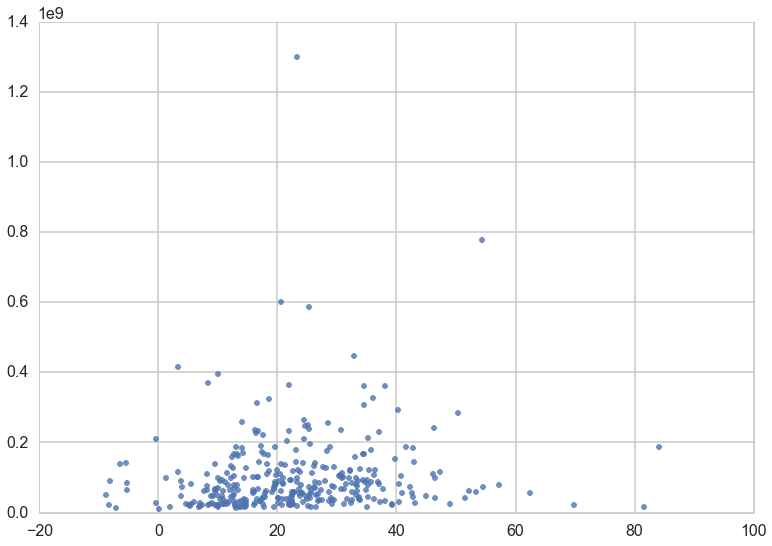

In [58]:
plt.plot(dftouse.valence_sum, dftouse.adj_gross, '.', alpha=0.8);

##Clustering

In [59]:
import gensim

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
#credit: Lab10
vectorizer = CountVectorizer(min_df=1, stop_words='english')
X=vectorizer.fit_transform(valence_df.text)

corpus=vectorizer.get_feature_names()
id2words = dict((v, k) for k, v in vectorizer.vocabulary_.iteritems())
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=2, update_every=1, chunksize=2000, passes=1)

lda.print_topics()


[u'0.030*movie + 0.025*br + 0.011*film + 0.009*like + 0.008*just + 0.008*good + 0.005*time + 0.005*bad + 0.005*story + 0.005*really',
 u'0.048*br + 0.015*film + 0.012*movie + 0.006*like + 0.005*good + 0.005*just + 0.004*really + 0.004*characters + 0.003*story + 0.003*time']

In [61]:
Xall=dftouse[['valence_sum', 'adj_gross']].values
from sklearn.mixture import GMM
n_clusters=2
clfgmm = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm.fit(Xall)
print clfgmm
gmm_means=clfgmm.means_
gmm_covar=clfgmm.covars_
print gmm_means, gmm_covar

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[  2.26511984e+01   9.20097877e+07]
 [  3.08919028e+01   8.14217839e+08]] [[  1.79419613e+02   1.06382161e+08]
 [  1.06382161e+08   7.07399527e+15]]


In [62]:
from scipy import linalg

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell.set_clip_box(splot.bbox)
    ell1 = mpl.patches.Ellipse(mean, 1 * v[0] ** 0.5, 1 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell1.set_clip_box(splot.bbox)
    ell3 = mpl.patches.Ellipse(mean, 3 * v[0] ** 0.5, 3 * v[1] ** 0.5,
                              180 + angle, color=color, lw=3, fill=False)
    ell3.set_clip_box(splot.bbox)
    #ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.add_artist(ell1)
    splot.add_artist(ell3)

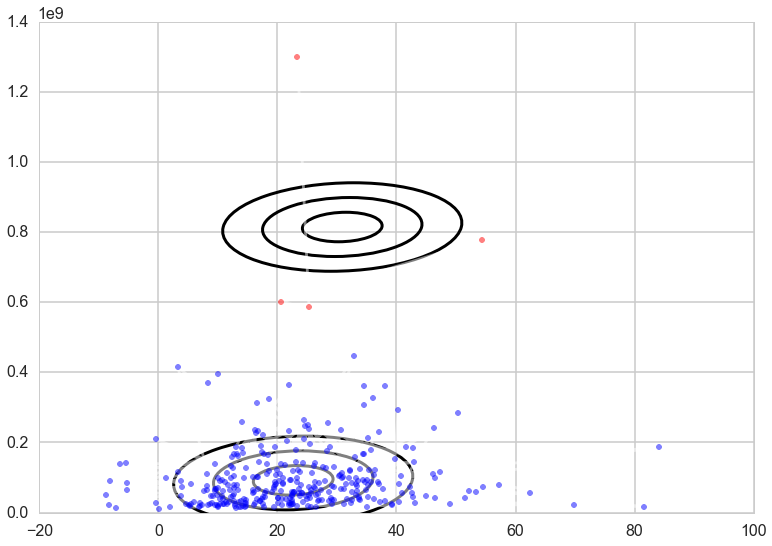

In [63]:
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
gmm_labels=clfgmm.predict(Xall)
for k, col in zip(range(n_clusters), ['blue','red']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.5)

This gives us a good approximation of two distinct clusters in our data. Basically, the movies that make more than 500 million dollars in total adjusted gross belongs to the red cluster, and the rest (which are the signifcant majority of the movies) belong to the blue cluster.

Let's try to see if we would get a better result with 3 clusters:

GMM(covariance_type='tied', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[  2.18593152e+01   7.36447081e+07]
 [  2.45745724e+01   1.36629515e+08]
 [  3.08921900e+01   8.14926414e+08]] [[  1.77916251e+02   7.15394460e+07]
 [  7.15394460e+07   6.26401705e+15]]


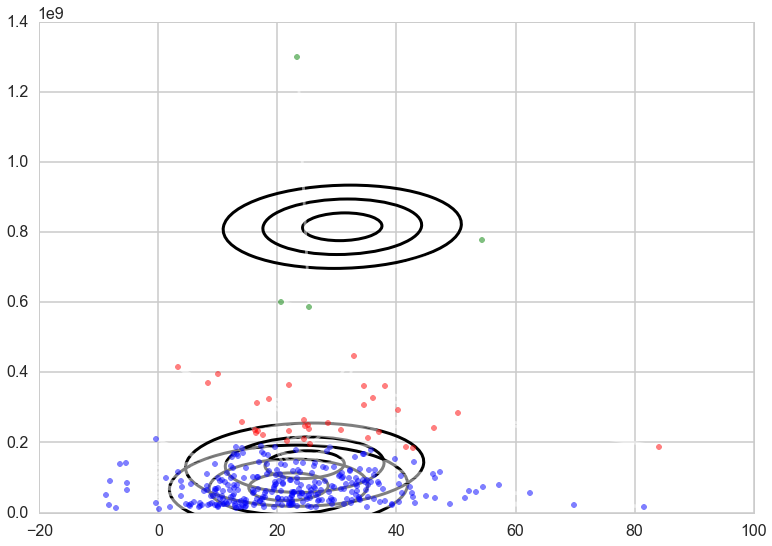

In [64]:
n_clusters=3
clfgmm3 = GMM(n_components=n_clusters, covariance_type="tied")
clfgmm3.fit(Xall)
print clfgmm
gmm_means=clfgmm3.means_
gmm_covar=clfgmm3.covars_
print gmm_means, gmm_covar
plt.figure()
ax=plt.gca()
plot_ellipse(ax, gmm_means[0], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[1], gmm_covar, 'k')
plot_ellipse(ax, gmm_means[2], gmm_covar, 'k')
gmm_labels=clfgmm3.predict(Xall)
for k, col in zip(range(n_clusters), ['blue','red', 'green']):
    my_members = gmm_labels == k
    ax.plot(Xall[my_members, 0], Xall[my_members, 1], 'w',
            markerfacecolor=col, marker='.', alpha=0.5)

Since there is so much overlap between the lower two clusters this time, we see that clustering into 2 groups is the better choice for our data. (We have also tried more clusters, but they similarly give worse results than the 2-clusters version)

## Bag of Words

### First import our dataset & dictionary

In [65]:
# with open("IMDB_dftouse_dict.json", "r") as fd:
#     IMDB_dftouse_dict = json.load(fd)
# maas_IMDB = pd.DataFrame(IMDB_dftouse_dict)

with open("valence_df_dict.json", "r") as fp:
    valence_df_dict = json.load(fp)
maas_IMDB = pd.DataFrame(valence_df_dict)

In [66]:
maas_IMDB.head()

movie_id       movie_name  n_scorables  pct_scorables  positive  stars                                               text                                                url  valence_avg  valence_sum
0        10027          Titanic          120       0.666667         1      7  Sure, Titanic was a good movie, the first time...  http://www.imdb.com/title/tt0120338/usercommen...     0.479760    38.380826
1        10028          Titanic           65       0.538462         1     10  When I saw this movie I was stunned by what a ...  http://www.imdb.com/title/tt0120338/usercommen...     0.508760    17.806611
10       10037          Titanic           95       0.589474         1      9  The ship may have sunk but the movie didn't!!!...  http://www.imdb.com/title/tt0120338/usercommen...     0.700832    39.246578
100      11015      Cliffhanger           84       0.500000         1      9  This movie is directed by Renny Harlin the fin...  http://www.imdb.com/title/tt0106582/usercommen...     0.794284    33.359933
1000     10544  The First Power          194       0.618557         0      4  When childhood memory tells you this was a sca...  http://www.imdb.com/title/tt0099578/usercommen...     0.132427    15.891239

In [67]:
maas_IMDB.shape

(4111, 10)

In [68]:
with open("happiness.json", "r") as fp:
    happiness = json.load(fp)

In [69]:
len(happiness)

10222

### Now we begin the Natural Language processing
This will take the form of a few steps. 
0. Punctuation: we will remove punctuation from reviews, so that all words can be recognized
1. Lemmatization: we will reduce words to lemmas
2. Removing stop words: we will remove common words from our vocabulary, because they are unlikely to have been used to express sentiment -- which is what we are interested in


### Emulating HW5
1. For each review create a list of nouns, and a list of adjectives
2. For the nouns, perform LDA to separate them into 2 topics to see if there are 2 topics that are relevant i.e. actors vs. plot or whether it's sequel or a stand alone movie
3. Run the sentiment analysis on the adjectives <b> (N.B. At this point it is still not on an external dataset) </b>
4. Putting the topics and sentiment analysis together (marrying the nouns & the adjectives) 
5. Estimate the overall mean for each movie on each topic

In [70]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

In [71]:
from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

### 1. For each review create a list of nouns, and a list of adjectives

In [72]:
import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

In [73]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [74]:
%%time
# review_parts = maas_IMDB.map(lambda x: get_parts(x.text))
review_parts = []
for index, row in maas_IMDB.iterrows():
    review_parts.append(get_parts(row.text))

CPU times: user 1min 40s, sys: 375 ms, total: 1min 41s
Wall time: 1min 41s


In [75]:
review_parts[1]

([[u'movie', u'movie'],
  [u'movie', u'rating'],
  [u'movie', u'acting'],
  [u'job'],
  [u'<br', u'day'],
  [u'effect', u'more.<br', u'movie', u'rent']],
 [[u'great'],
  [u'star'],
  [u'superb'],
  [u'better'],
  [u'rainy'],
  [u'acting', u'special']])

### 2. For the nouns, perform LDA to separate them into 2 topics

In [76]:
ldadata = [ele[0] for ele in review_parts]

In [77]:
ldadata

[[[u'sure', u'movie', u'time', u'time', u'opinion', u'film', u'change'],
  [u'time', u'movie', u'ooh'],
  [u'time', u'movie', u'thinking', u'd**n', u'ship'],
  [u'time'],
  [u'acting', u'film'],
  [u'oscar', u'film'],
  [u'movie', u'film'],
  [u'film'],
  [u'eye', u'character', u'film'],
  [u'performance', u'hand'],
  [u'director', u'film', u'magnitude'],
  [u'lesson', u'movie', u'love-story', u'filmmaker', u'romance', u'movie'],
  [u'film']],
 [[u'movie', u'movie'],
  [u'movie', u'rating'],
  [u'movie', u'acting'],
  [u'job'],
  [u'<br', u'day'],
  [u'effect', u'more.<br', u'movie', u'rent']],
 [[u'picture'],
  [u'scene', u'dinner', u'table', u'scene', u'family', u'friend'],
  [u'look',
   u'face',
   u'woman',
   u'room',
   u'future',
   u'husband.<br',
   u'connection',
   u'movie',
   u'movie',
   u'stuff'],
  [u'mom', u'associate', u'husband', u'wealth'],
  [u'risk.<br', u'movie'],
  [u'story', u'flow', u'actor']],
 [[u'movie', u'miracle'],
  [u'mountain', u'terrorist'],
  [u'mou

In [78]:
import itertools as IT
import collections

def flatten_iter(iterable, ltypes=collections.Iterable):
    remainder = iter(iterable)
    while True:
        first = next(remainder)
        if isinstance(first, ltypes) and not isinstance(first, basestring):
            remainder = IT.chain(first, remainder)
        else:
            yield first

In [79]:
vocab_raw = list(flatten_iter(ldadata))
#removing duplicates
vocab_unique = []
for i in vocab_raw:
    if i not in vocab_unique:
        vocab_unique.append(i)

In [80]:
vocab = {}
for i in range(len(vocab_unique)):
    vocab[vocab_unique[i]] = i
    
id2word = {}
for i in range(len(vocab_unique)):
    id2word[i] = vocab_unique[i]

In [81]:
id2word[0], vocab.keys()[5], vocab[vocab.keys()[5]]

(u'sure', u'yellow', 5224)

In [82]:
from collections import defaultdict

def auxillary_function(ldadata, vocab):
    d = defaultdict(int)
    for i in ldadata: 
        index = vocab[i]
        d[index] += 1
    return d.items()

In [83]:
all_reviews = []
for i in ldadata: # into a review
    this_review = []
    for j in i:
        for k in j: 
            if k not in this_review: 
                this_review.append(k)
    all_reviews.append(this_review)

corpus = []
for i in all_reviews: 
    corpus.append(auxillary_function(i, vocab))

In [84]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1)],
 [(1, 1),
  (10, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(1, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(64, 1),
  (1, 1),
  (66, 1),
  (67, 1),
  (4, 1),
  (69, 1),
  (68, 1),
  (65, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(1, 1),
  (2, 1),
  (25, 1),
  (30, 1),
  (48, 1),
  (55, 1),
  (61, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),


In [85]:
lda2 = gensim.models.ldamodel.LdaModel(corpus, num_topics=2,id2word = id2word,update_every=1,chunksize=20000,passes=1)

In [86]:
lda2.print_topics()

[u'0.021*movie + 0.019*film + 0.010*character + 0.010*time + 0.009*story + 0.008*person + 0.008*way + 0.007*scene + 0.007*plot + 0.006*thing',
 u'0.025*movie + 0.015*film + 0.012*character + 0.012*time + 0.010*story + 0.009*scene + 0.007*thing + 0.007*person + 0.007*actor + 0.006*plot']

In [87]:
for bow in corpus[0:900:15]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]
[(0, 0.79351841476076634), (1, 0.20648158523923363)]
sure movie time opinion film change ooh thinking d**n ship acting oscar eye character performance hand director magnitude lesson love-story filmmaker romance
[(1, 1), (4, 1), (342, 1), (135, 1), (267, 1), (12, 1), (13, 1), (15, 1), (24, 1), (150, 1), (151, 1), (280, 1), (26, 1), (346, 1), (176, 1), (214, 1), (304, 1), (294, 1), (295, 1), (296, 1), (297, 1), (298, 1), (299, 1), (300, 1), (301, 1), (302, 1), (303, 1), (48, 1), (305, 1), (306, 1), (307, 1), (308, 1), (309, 1), (310, 1), (311, 1), (312, 1), (313, 1), (314, 1), (315, 1), (316, 1), (317, 1), (318, 1), (319, 1), (320, 1), (321, 1), (322, 1), (323, 1), (324, 1), (325, 1), (326, 1), (327, 1), (328, 1), (329, 1), (330, 1), (55, 1), (332, 1), (333, 1), (78, 1), (335, 1), (336, 1), (337, 1), (

It looks like <b> topic 2</b> is about the external factors of a movie -- who the actors are and how production went, and <b> topic 1</b> is about the intrinsic factors of a movie -- the character development and plot. Examples: 
    * words like "movie" "actor" "film" or "budget" "film" have higher topic 2 ratings. 
    * words like "relationship" "scenery" "personality" have a higher topic 1 rating

### 3. Run the sentiment analysis on the adjectives

In [88]:
nbdata = [ele[1] for ele in review_parts]

In [89]:
adj_raw = list(flatten_iter(nbdata))
#removinc duplicates
adj_unique = []
for i in adj_raw:
    if i not in adj_unique:
        adj_unique.append(i)

In [90]:
adjvocab = {}
for i in range(len(adj_unique)):
    adjvocab[adj_unique[i]] = i

In [91]:
adjvocab['great']

7

In [92]:
len(adjvocab)

7335

In [93]:
import itertools
Xarray = []
for i in nbdata: # into a review
    Xarraypre = " ".join(list(itertools.chain.from_iterable(i)))
    Xarray.append(Xarraypre)

In [94]:
# making the response array based off of the sentiment dictionary 'happiness' there is valence_avg and valence_sum
resparray = []
for index, row in maas_IMDB.iterrows():
    if row.valence_avg > 0: # need to make it binomial because that's how the calibration/cv score works
        resparray.append(1)
    else: 
        resparray.append(0)

In [95]:
print  len(Xarray), len(resparray)
print Xarray[0]

4111 4111
good second love-story romantic second annoying impressive bad great glad half-good suprised worst wonderful talented crummy single possible mere


In [96]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(Xarray)), train_size=0.7)
mask=np.ones(len(Xarray), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [97]:
X=np.array(Xarray)
y=np.array(resparray)

In [98]:
y

array([1, 1, 1, ..., 1, 0, 1])

In [99]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

In [100]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews
    
Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is positive
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    neg = y == 0
    pos = ~neg
    return prob[neg, 0].sum() + prob[pos, 1].sum()

In [101]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [102]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [104]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(vocabulary =adjvocab, min_df = min_df)       
        Xthis, Ythis = make_xy(X[mask], y[mask], vectorizer)
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xthis, Ythis, log_likelihood)
        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [105]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000010


Accuracy on training data: 0.97
Accuracy on test data:     0.90


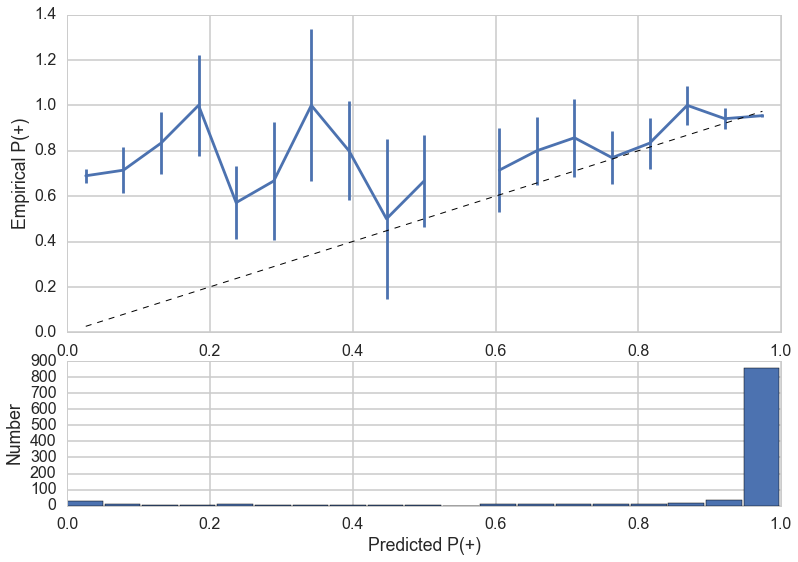

In [106]:
vectorizer = CountVectorizer(vocabulary =adjvocab, min_df=best_min_df)
Xnew, Ynew = make_xy(X,y, vectorizer)
xtrain, xtest, ytrain, ytest = train_test_split(Xnew, Ynew)
clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

calibration_plot(clf, xtest, ytest)

### 4. Putting the topics and sentiment analyses together


In [107]:
vectorizer_alladj = CountVectorizer(min_df=best_min_df,vocabulary = adjvocab)
X_alladj, Y_alladj = make_xy(X[mask],y[mask], vectorizer_alladj)
clf_alladj = MultinomialNB(alpha=best_alpha).fit(X_alladj, Y_alladj)

logpositives = dict(zip(vectorizer_alladj.get_feature_names(),clf_alladj.feature_log_prob_[0]))
lognegatives = dict(zip(vectorizer_alladj.get_feature_names(),clf_alladj.feature_log_prob_[1]))

In [108]:
def calc_pplus(adjlist, lp, ln, pp,pn):
    sgivenpos = 0
    sgivenneg = 0
    for adj in adjlist:
        sgivenpos += lp[adj]
        sgivenneg += ln[adj]
    return(np.exp(sgivenpos)*pp)/(np.exp(sgivenpos)*pp + np.exp(sgivenneg)*pn)

In [109]:
reviews=[]
for index, row in maas_IMDB.iterrows():
    reviews.append(row.movie_id)

In [110]:
reviews

[10027.0,
 10028.0,
 10037.0,
 11015.0,
 10544.0,
 10714.0,
 10715.0,
 10716.0,
 10717.0,
 10718.0,
 10719.0,
 10753.0,
 10754.0,
 10755.0,
 11016.0,
 10756.0,
 10757.0,
 10758.0,
 10759.0,
 10760.0,
 10775.0,
 10776.0,
 10777.0,
 10778.0,
 10779.0,
 11017.0,
 10780.0,
 10781.0,
 10782.0,
 10783.0,
 10784.0,
 10785.0,
 10786.0,
 10787.0,
 10788.0,
 10794.0,
 11018.0,
 10795.0,
 10796.0,
 10797.0,
 10798.0,
 10799.0,
 10800.0,
 10801.0,
 10802.0,
 10803.0,
 10804.0,
 11019.0,
 10805.0,
 10806.0,
 10807.0,
 10808.0,
 10809.0,
 10810.0,
 10811.0,
 10812.0,
 10826.0,
 10827.0,
 11020.0,
 10828.0,
 10829.0,
 10830.0,
 10831.0,
 10832.0,
 10833.0,
 10834.0,
 10835.0,
 10836.0,
 10837.0,
 11021.0,
 10838.0,
 10902.0,
 10903.0,
 10904.0,
 10905.0,
 10906.0,
 10907.0,
 10908.0,
 10909.0,
 10910.0,
 11022.0,
 10911.0,
 10912.0,
 10913.0,
 10914.0,
 11035.0,
 11088.0,
 11089.0,
 11090.0,
 11091.0,
 11092.0,
 11023.0,
 11093.0,
 11118.0,
 11119.0,
 11120.0,
 11158.0,
 11159.0,
 11160.0,
 11161.0,


In [111]:
len(review_parts),len(reviews)

(4111, 4111)

In [112]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==2:
        t1,t2=tee
        if t2[1] >= t1[1]:#get higher probability topic
            topicis=t2[0]
        else:
            topicis=t1[0]
    elif len(tee)==1:#if only one was provided its very high probability. Take it
        teetuple=tee[0]
        topicis=teetuple[0]
    return topicis

In [113]:
priorp = np.mean(resparray)
priorn = 1 - priorp
priorp, priorn

(0.92897105327171003, 0.071028946728289966)

In [114]:
counter=0
reviewdict={}
for i, rid in enumerate(reviews):
    rlist=[]
    nlist, alist = review_parts[i]
    ln=len(nlist)
    localbow=corpus[counter:counter+ln]
    for bow, adj, noun in zip(localbow, alist, nlist):
        doc=" ".join([id2word[e[0]] for e in bow])
        pplus=calc_pplus(adj, logpositives, lognegatives, priorp, priorn)
        topicis=choose_topic(lda2, bow)
        ldict={"topic": topicis, 'pplus':pplus}
        rlist.append(ldict)
    reviewdict[rid]=rlist
    counter=counter+ln

In [115]:
list_of_dicts=[]
for index, row in maas_IMDB.iterrows():
    revs=reviewdict[row.movie_id]
    for r in revs:
        r2=r.copy()
        r2['movie_id']=row.movie_name
        r2['url']=row.url
        r2['review_id']=row.movie_id
        r2['stars']=row.stars
        r2['valence_avg']=row.valence_avg
        r2['valence_sum']=row.valence_sum
        list_of_dicts.append(r2)

In [116]:
completedf=pd.DataFrame(list_of_dicts)
completedf.head()

movie_id     pplus  review_id  stars  topic                                                url  valence_avg  valence_sum
0  Titanic  0.795903      10027      7      0  http://www.imdb.com/title/tt0120338/usercommen...      0.47976    38.380826
1  Titanic  0.927420      10027      7      0  http://www.imdb.com/title/tt0120338/usercommen...      0.47976    38.380826
2  Titanic  0.884421      10027      7      1  http://www.imdb.com/title/tt0120338/usercommen...      0.47976    38.380826
3  Titanic  0.184704      10027      7      1  http://www.imdb.com/title/tt0120338/usercommen...      0.47976    38.380826
4  Titanic  0.816369      10027      7      0  http://www.imdb.com/title/tt0120338/usercommen...      0.47976    38.380826

In [117]:
completedf.shape

(2815, 8)

### 5. Estimate the overall mean for each movie on each topic

In [118]:
def get_stats(group):
    min_pplus = group.pplus.min()
    max_pplus = group.pplus.max()
    rid = group.movie_id.unique()
    valence_avg = group.valence_avg.mean()
    valence_sum = group.valence_sum.mean()
    count = group.topic.count()
    if count == 1: 
        varj = 0
    else: 
        varj = group.pplus.var(ddof=1)
    mean_pplus = group.pplus.mean()
    stars = group.stars.mean()
    return pd.DataFrame({'min': min_pplus, 'max':max_pplus ,'valence_avg': valence_avg,'valence_sum':valence_sum, 
                         'count': count,'var': varj, 'mean': mean_pplus, 'stars': stars}, index=rid)

In [247]:
%%time
dftouse_bow=completedf.groupby(['review_id', 'topic']).apply(get_stats).reset_index()

CPU times: user 1.02 s, sys: 9.25 ms, total: 1.03 s
Wall time: 1.03 s


In [248]:
print dftouse.shape
dftouse_bow.head()

(707, 11)


review_id  topic       level_2  count       max      mean       min  stars  valence_avg  valence_sum       var
0       7455      0  Corky Romano      2  0.938601  0.935001  0.931401      3     0.040475     0.566644  0.000026
1       7456      0  Corky Romano      2  0.909971  0.874460  0.838949      2     0.196665     8.259933  0.002522
2       7456      1  Corky Romano      4  0.964899  0.689376  0.024227      2     0.196665     8.259933  0.201585
3       7457      0  Corky Romano      2  0.998090  0.981825  0.965560      4     0.218332     9.169933  0.000529
4       7457      1  Corky Romano      3  0.927105  0.829115  0.748561      4     0.218332     9.169933  0.008197

In [249]:
dftouse_bow[dftouse_bow.review_id==10037]

review_id  topic  level_2  count       max      mean       min  stars  valence_avg  valence_sum       var
265      10037      0  Titanic      2  0.872011  0.482266  0.092521      9     0.700832    39.246578  0.303802
266      10037      1  Titanic      4  0.873249  0.658005  0.422276      9     0.700832    39.246578  0.034283

### Using the NLTK library

In [122]:
! pip install nltk

In [131]:
import nltk
from nltk.corpus import sentiwordnet as swn

In [132]:
happy = swn.senti_synset('happy.n.03')
print(happy)

LookupError: 
**********************************************************************
  Resource u'corpora/sentiwordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/jasondong/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [ ]:
type(swn)

In [257]:
groupby_movie = dftouse_bow.groupby(['level_2','topic'])

val_avg = groupby_movie['valence_avg','valence_sum','var','max','mean','min','count'].mean()
topic01 = val_avg.reset_index().set_index('level_2')
topic1 = topic01[topic01.topic==1].rename(columns={'valence_avg':'valence_avg_t1'
                                                   ,'valence_sum':'valence_sum_t1'
                                                   ,'var':'var_t1','max':'max_t1'
                                                   ,'mean':'mean_t1','min':'min_t1'
                                                   ,'count':'count_t1'})
topic0 = topic01[topic01.topic==0].rename(columns={'valence_avg':'valence_avg_t0'
                                                   ,'valence_sum':'valence_sum_t0'
                                                   ,'var':'var_t0','max':'max_t0'
                                                   ,'mean':'mean_t0','min':'min_t0'
                                                   ,'count':'count_t0'})

groupby_movie2 = dftouse_bow.groupby(['level_2'])
stars = groupby_movie2.stars.unique()

combinedf = pd.concat([dftouse0, topic0], axis=1, join_axes=[dftouse0.index])
combinedf = pd.concat([combinedf, topic1], axis=1, join_axes=[combinedf.index])

dftouse = combinedf[~combinedf['count_t0'].map(np.isnan)].fillna(0)

In [259]:
dftouse.shape

(54, 31)

##Classification

##### Classification

We are interested in classifying whether movies are blockbusters or not, which is defined as having a grossing of over 100M. We would like to see to what extent can our sentiment analysis predict whether a given movie has been a blockbuser.

We will first train classifiers on two variables, our valence average scores for topic 1 and topic 0. This is because we are interested in seeing to what extent our bag of words analysis has produced valences of reviews that have predictive powers. The classifiers we will be using are the following:
1. Logistic regression
2. Support Vector Machine
3. Decision tree classifier
4. AdaBoost classifier
5. GradientBooster classifier

With these classifiers we will visualize how these classifiers perform through a contour plot. We will also compare how these classifiers compare to each other using ROC curves.

We will also split betwen training and testing sets and choose the classifier that performs best on the testing set.

Next, we will train classifiers on a larger list of variables similar what we did for regression. For example, this will include other valence scores we've calculated using the LabMT dictionary, the variance of valence scores across reviews for a given movie and etc. In addition, we will be trying using another classifier that we were not able to use when we trained on two variables:

6. Random forest classifier

Again, we will split between training and testing set and select the classifier that performs the best on the testing set. We will visualize how well the classifiers perform using a ROC curve.

In [646]:
with open("dftouse.json", "r") as fp:
    dftouse2_dict = json.load(fp)
dftouse2 = pd.DataFrame(dftouse2_dict)

In [1081]:
# dftouse3 = dftouse2[~dftouse2.valence_avg.map(np.isnan)]
dftouse2 = dftouse2[~dftouse2.stars.map(isNA)]
dftouse2['stars'] = dftouse2['stars'].astype(int)
dftouse2.head()

close_date close_year      gross  n_scorables      open_date open_year  opening_gross  opening_theaters  pct_scorables  rank                                       review_title  stars                                               text  theaters                         title  valence_avg  valence_sum  year
0               NaN       1990  285761243          144   632448000000      1990       17081997              1202       0.701389     1                      My favourite Christmas movie!     10   it just isn't christmas if i don't watch home...      2173                    Home Alone     0.758622    76.620792  1990
1               NaN       1990  285761243           65   632448000000      1990       17081997              1202       0.738462     1                            Very funny family movie      8   this is a very funny movie for kids and peopl...      2173                    Home Alone     1.408094    67.588495  1990
10              NaN       1990    7698010          364   633052800000      1990          57959                 2       0.434066   109                          Emasculation Proclamation      5   almost  but not quite  benniferidiotically ta...       240             Mr. & Mrs. Bridge     0.237925    37.592131  1990
100    1.137542e+12       2006     743847           87  1136851200000      2006          68779                 7       0.482759   251                      Dusting off great LA memoirs!     10   john fante wrote a great book called ask the ...       111                  Ask the Dust     0.469998    19.739933  2006
10000  1.137024e+12       2006      65429          183  1137715200000      2006          12376                 3       0.677596   404  Touching, inspiring, hits close to home, no ma...     10   i knew i would love this movie and the charac...        10  The Real Dirt on Farmer John     0.597825    74.130280  2006

In [1250]:
dftouse.year

title
Home Alone                                  1990
Ghost                                       1990
Dances with Wolves                          1990
Pretty Woman                                1990
Teenage Mutant Ninja Turtles                1990
The Hunt for Red October                    1990
Total Recall                                1990
Dick Tracy                                  1990
Kindergarten Cop                            1990
Back to the Future Part III                 1990
Presumed Innocent                           1990
Days of Thunder                             1990
Another 48 HRS.                             1990
Bird on a Wire                              1990
The Godfather Part III                      1990
Flatliners                                  1990
Misery                                      1990
Edward Scissorhands                         1990
Problem Child                               1990
Arachnophobia                               1990
Awakenings    

In [1247]:
dftouse2.head()

gold = dftouse2.groupby("title")

n_scorables = gold.n_scorables.mean()
pct_scorables = gold.pct_scorables.mean()
review_count = gold.title.count()
open_gross = gold.opening_gross.mean()
gross = gold.gross.mean()
valence_avg = gold.valence_avg.mean()
valence_sum = gold.valence_sum.mean()
valence_avg_var = gold.valence_avg.var()
valence_sum_var = gold.valence_sum.var()
star_avg = gold.stars.mean()
theaters = gold.theaters.mean()
open_theaters = gold.opening_theaters.mean()



year = gold.year.max()

# positive = gold.positive.mean()


In [1248]:
dftouse =  pd.concat([year,theaters,open_theaters,star_avg,valence_avg_var,valence_sum_var], axis=1, join_axes=[indexed_df.index])
dftouse = dftouse.rename(columns={'valence_avg':'valence_avg_var','valence_sum':'valence_sum_var'})
dftouse = pd.concat([dftouse,gross,n_scorables,pct_scorables,review_count,valence_avg,valence_sum,open_gross]
                    , axis=1, join_axes=[indexed_df.index])
dftouse=dftouse.rename(columns={'opening_gross':'adj_opening_gross'})
dftouse['adj_opening_gross_bin'] = 1*(dftouse.gross>100000000)
dftouse['abs_valence_avg'] = np.abs(dftouse['valence_avg']-np.mean(dftouse['valence_avg']))
dftouse = dftouse.dropna()
dftouse = dftouse[dftouse.title>20]


dftouse.shape
# flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)
# flattened_df = pd.concat([flattened_df, star_avg], axis=1, join_axes=[indexed_df.index])
# flattened_df.rename(columns={'stars': 'star_avg'}, inplace=True)
# flattened_df = pd.concat([flattened_df, positive], axis=1, join_axes=[indexed_df.index])
# [~dftouse['title'].map(np.isnan)]

(2302, 15)

In [750]:
dftouse.adj_opening_gross_bin.mean()

0.2203602848764139

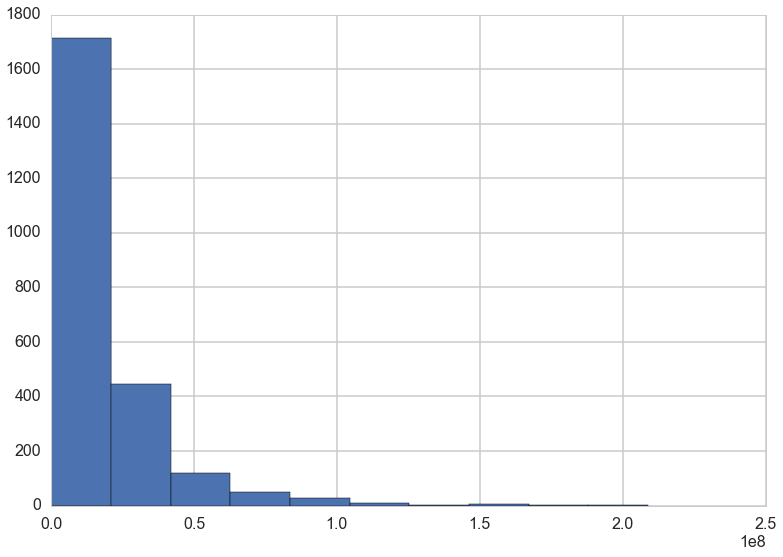

In [1080]:
plt.hist(dftouse.adj_opening_gross);

Let's define all the functions needed to do classificaiton. We write one main function called do_classify that inputs a classifier, data to train over and outputs the performance of accuracy score of the classifier on test and training data as well as the confusion matrix. We write a function called cv_optimize that optimizes a classifier given the parameters that are fed in. We also create functions to make ROC curves and contour plots.

In [875]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    print clf.__class__
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [867]:
clflog1.__class__

sklearn.linear_model.logistic.LogisticRegression

In [870]:
print clflog1.__class__

<class 'sklearn.linear_model.logistic.LogisticRegression'>


In [126]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [877]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    plt.title(clf.__class__)
    return ax 

In [685]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [907]:
def plot_2tree(ax, Xtr, Xte, ytr, yte, clf, plot_train = True, plot_test = True, lab = ['Feature 1', 'Feature 2'], mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    # Create a meshgrid as our test data
    plt.figure(figsize=(15,10))
    plot_step= 0.05
    xmin, xmax= Xtr[:,0].min(), Xtr[:,0].max()
    ymin, ymax= Xtr[:,1].min(), Xtr[:,1].max()
    xx, yy = np.meshgrid(np.arange(xmin, xmax, plot_step), np.arange(ymin, ymax, plot_step))

    # Re-cast every coordinate in the meshgrid as a 2D point
    Xplot= np.c_[xx.ravel(), yy.ravel()]


    # Predict the class
    Z = clfTree1.predict( Xplot )

    # Re-shape the results
    Z= Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap= cmap_light, alpha=0.3)
  
    # Overlay training samples
    if (plot_train == True):
        plt.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, alpha=alpha,edgecolor="k") 
    # and testing points
    if (plot_test == True):
        plt.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s")

    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.title("Boundary for decision tree classifier",fontsize=14)

Now let's train all the classifiers on either two variables or a larger list of variables (explained above).

In [876]:
%%time

itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.6)
mask_classify=np.ones(dftouse.shape[0], dtype='int')
mask_classify[itrain]=1
mask_classify[itest]=0
mask_classify = (mask_classify==1)


# Xnames = ['year','star_avg','review_count','positive','n_scorables','pct_scorables','valence_avg',
#          'valence_avg_t0','valence_sum_t0','var_t0','max_t0','mean_t0','min_t0','count_t0','topic','valence_avg_t1',
#           'valence_sum_t1','var_t1','max_t1','mean_t1','min_t1','count_t1']

two_features = ['valence_avg','pct_scorables']
Xnames = ['valence_avg','pct_scorables','n_scorables','valence_sum',
          'valence_avg_var','valence_sum_var','abs_valence_avg']

clflog1 = LogisticRegression()
parameters_log = {"C": [0.000000001, 0.00000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,]}
clflog1, Xtrain, ytrain, Xtest, ytest=do_classify(clflog1, parameters_log, dftouse, 
                                                 two_features,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)
print ""


from sklearn.svm import SVC
clfsvm1 = SVC(kernel="linear")
parameters_svc = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm1, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm1, parameters_svc, dftouse, 
                                                 two_features,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)

print ""

from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters_tree = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

clfTree1, Xtrain, ytrain, Xtest, ytest=do_classify(clfTree1, parameters_tree, dftouse, 
                                                 two_features,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)

print ""



from sklearn.ensemble import AdaBoostClassifier

clfAda1 = AdaBoostClassifier()

parameters_adaboost = {"n_estimators": range(10, 60)}
clfAda1, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda1, parameters_adaboost, 
                                                       dftouse, two_features, 'adj_opening_gross_bin', 
                                                   1, mask=mask_classify)

print ""


from sklearn.ensemble import GradientBoostingClassifier

clfGB1 = GradientBoostingClassifier()

parameters_GB = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB1, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB1, parameters_GB, 
                                                       dftouse, two_features, 'adj_opening_gross_bin', 1
                                                  , mask=mask_classify)




# Xtr=np.concatenate((Xtrain, Xtest))
# plt.figure()
# ax=plt.gca()
# nonamebob = points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog1)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[742   0]
 [212   0]]
########################################################

<class 'sklearn.svm.classes.SVC'>
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[742   0]
 [212   0]]
########################################################

<class 'sklearn.tree.tree.DecisionTreeClassifier'>
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[742   0]
 [212   0]]
########################################################

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[740   2]
 [212   0]]


/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.




Now let's print out the contour plots, accuracy scores and ROC curves to see which classifier performed the best

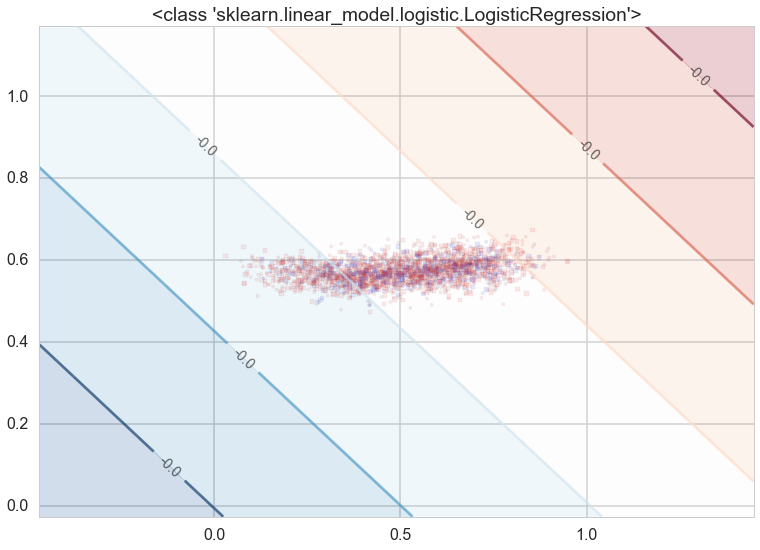

In [882]:
plt.figure()
ax=plt.gca()
# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog1, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog1, prob=False);

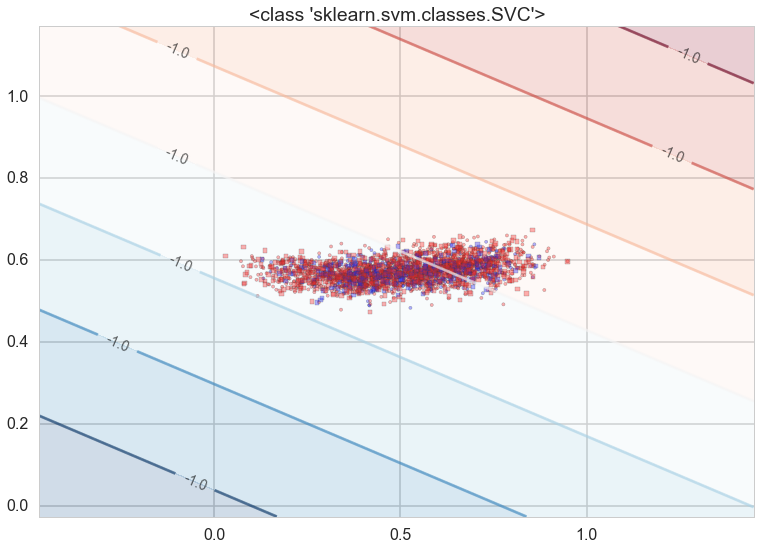

In [898]:
Xtr=np.concatenate((Xtrain, Xtest))
# plt.figure()
# ax=plt.gca()
# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1);
# points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, x,prob=False);

plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1, prob=False);


ValueError: Number of features of the model must  match the input. Model n_features is 2 and  input n_features is 7 

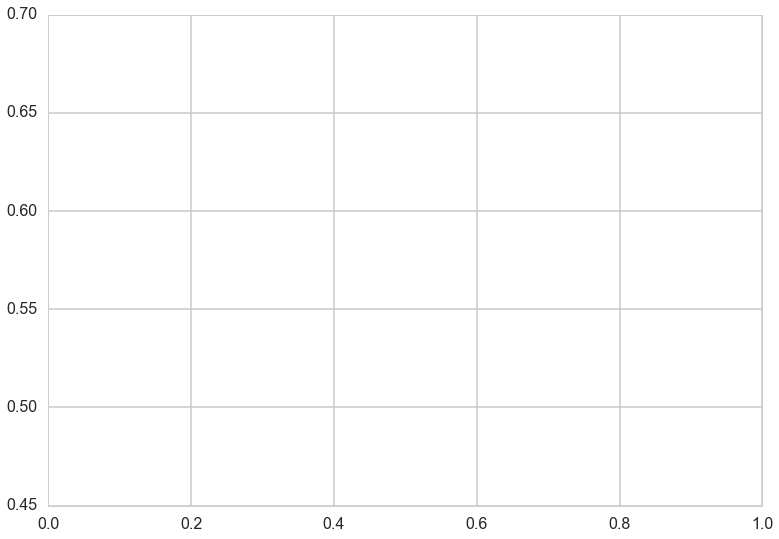

In [853]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfAda1, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfAda1);


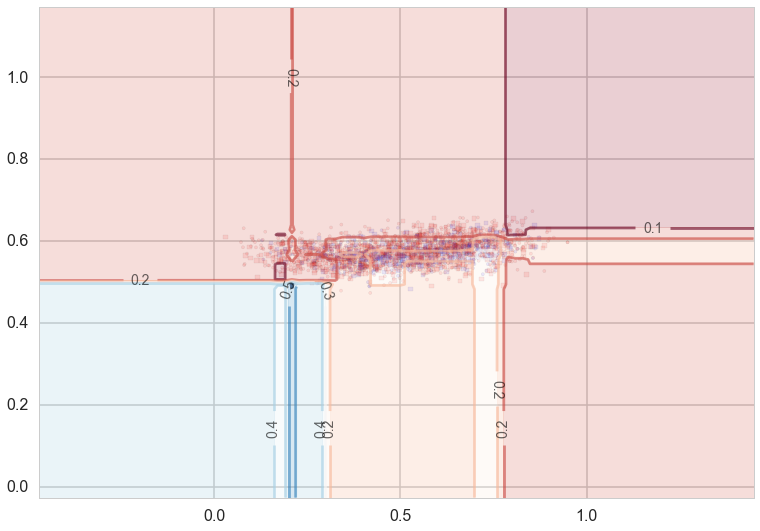

In [836]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfGB1, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfGB1);

In [900]:
plt.subplots

<function matplotlib.pyplot.subplots>

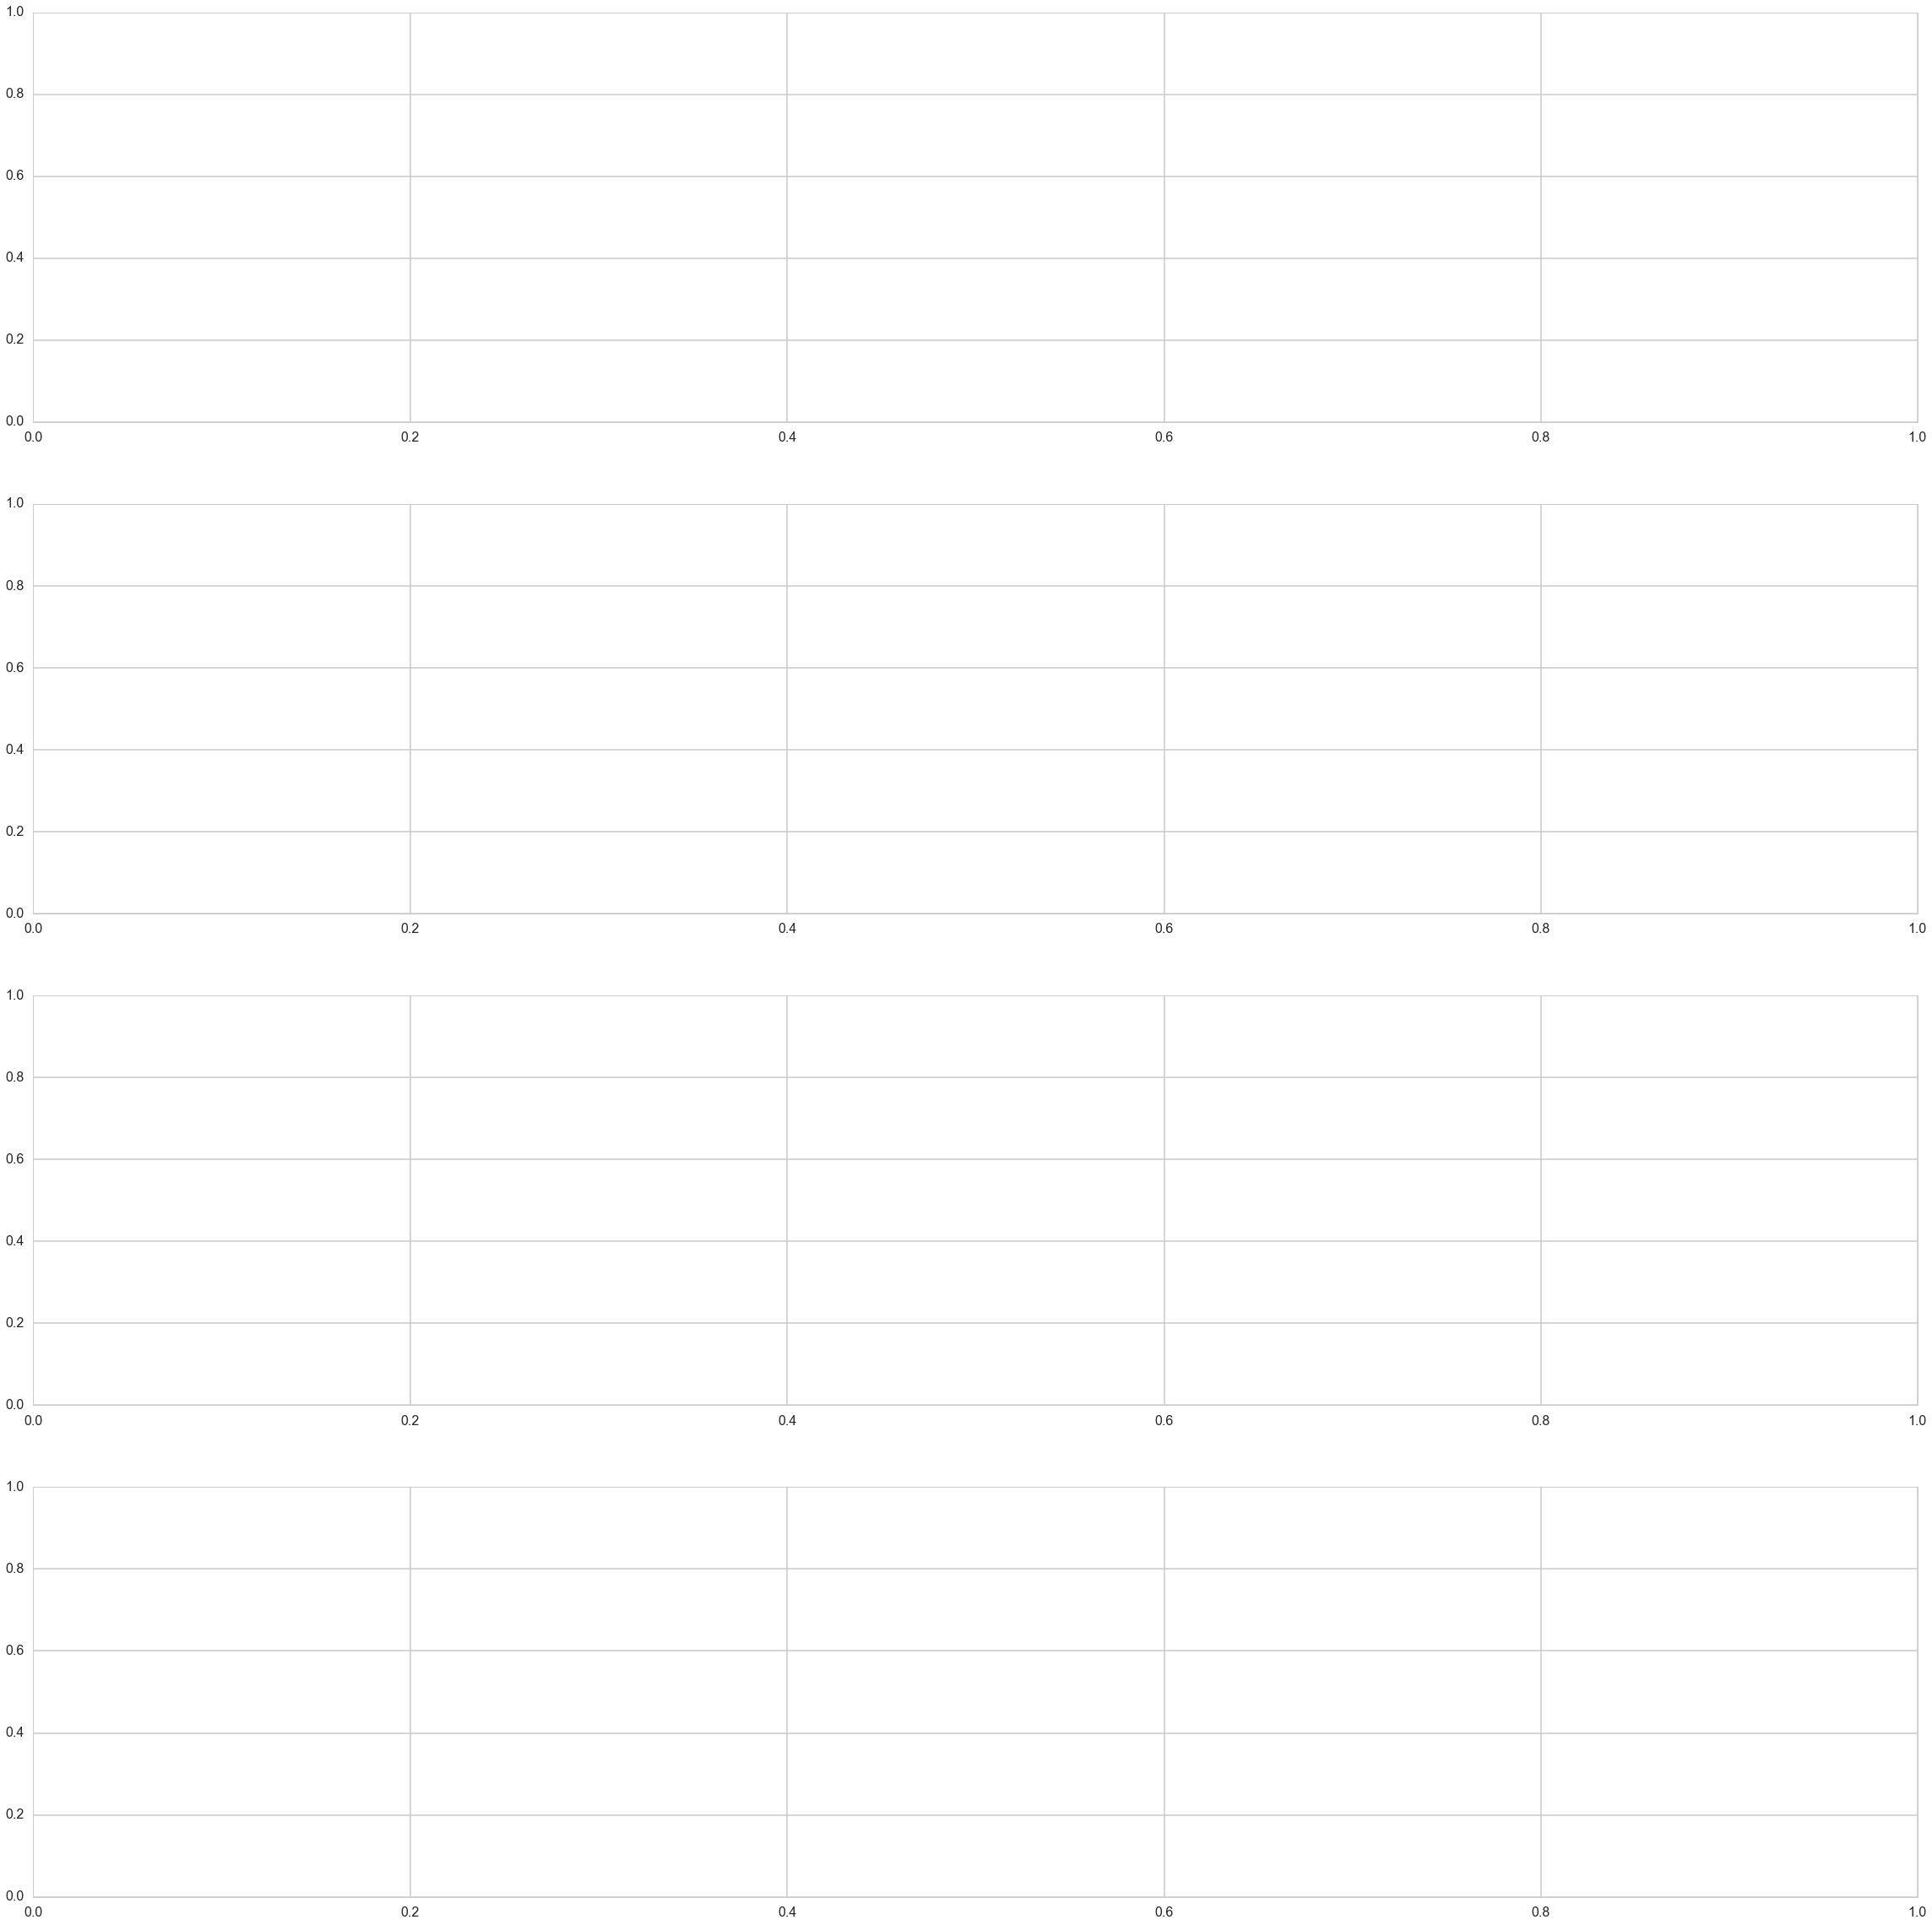

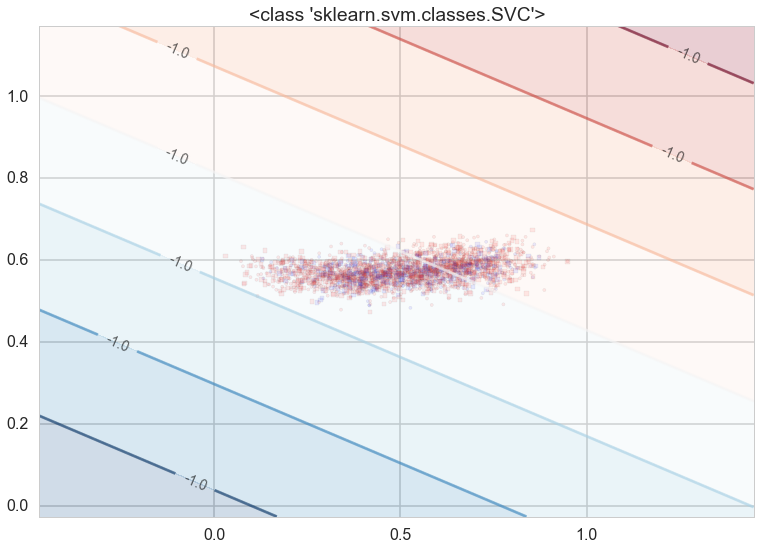

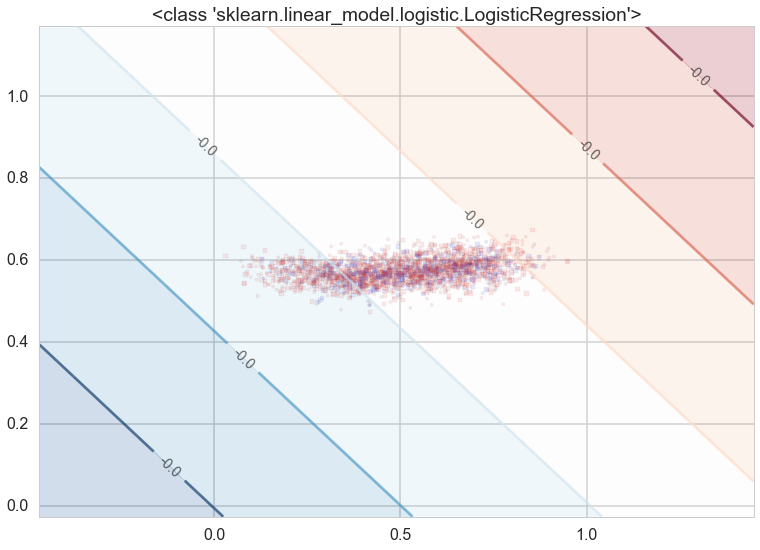

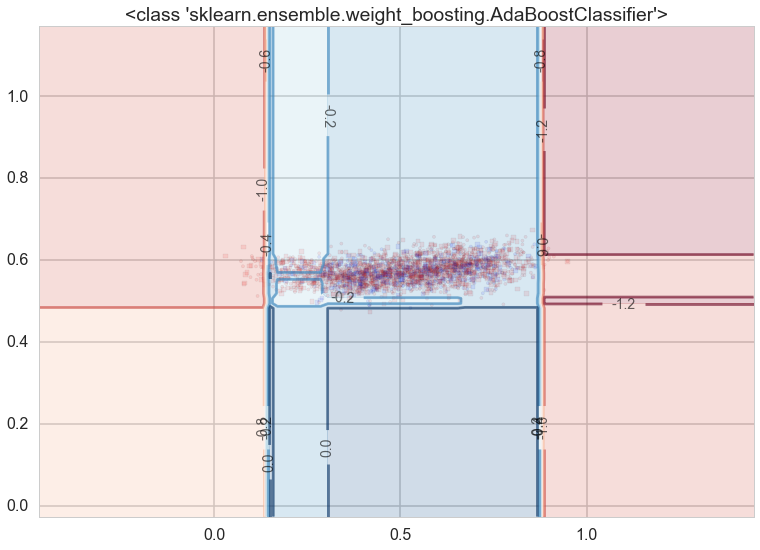

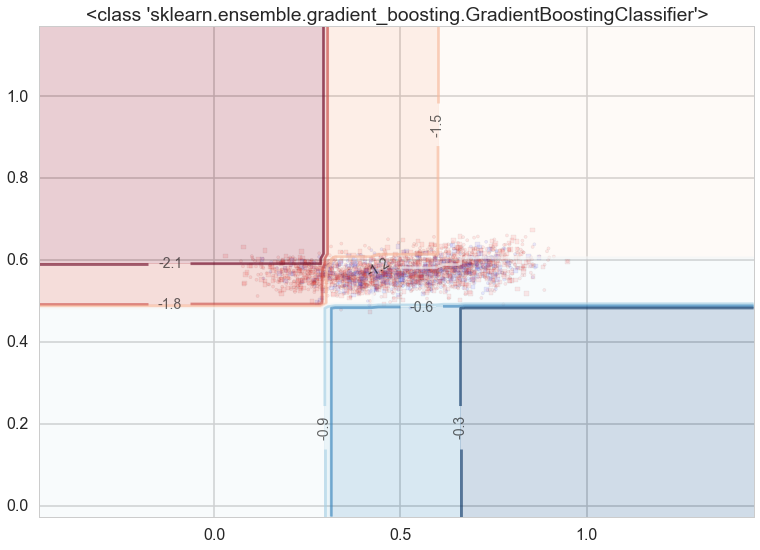

In [905]:
# Xtr=np.concatenate((Xtrain, Xtest))
# plt.figure()
# ax=plt.gca()

classifiers1 = [clfsvm1,clflog1,clfAda1,clfGB1]

fig, axes = plt.subplots(nrows = len(classifiers1), ncols = 1, figsize=(40, 40))
for (ax, x) in zip(axes.ravel(), classifiers1):
    Xtr=np.concatenate((Xtrain, Xtest))
    plt.figure()
    ax=plt.gca()
#     points_plot(ax, Xtrain, Xtest, ytrain, ytest, x, mesh=False, alpha=0.001);
    points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, x,prob=False);

    
    
#     points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, x)
    
#     m, b = np.polyfit(x, dftouse.adj_opening_gross, 1)
# #     ax.plot(x, m*x + b, '-')
#     ax.plot(x, dftouse.adj_opening_gross, '.',x, m*x + b, '-')
#     ax.set_title(title)
#     ax.set_xlabel(xlabel)
#     ax.set_ylim(-1000, 1.8*1e8)
    
    

# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog1);
# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1);
# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfTree1);
# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfAda1);
# points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfGB1);

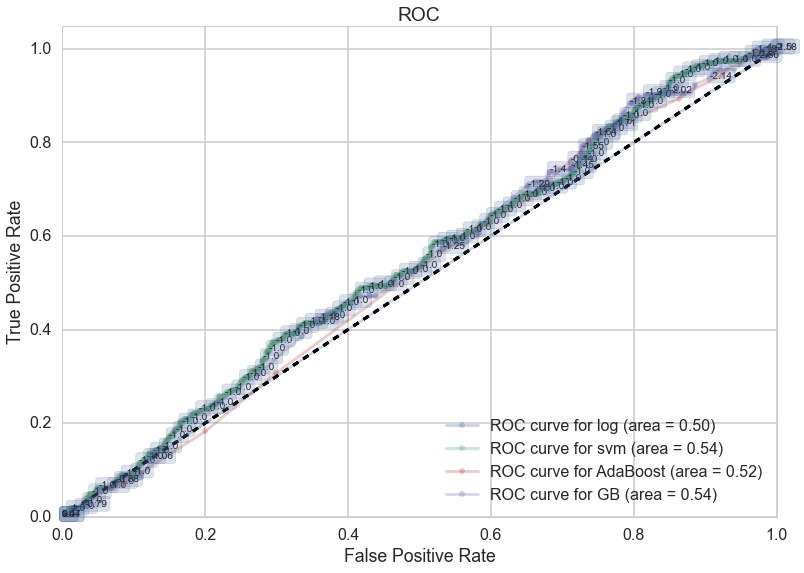

In [846]:
ax1=make_roc("log", clflog1, ytest, Xtest, labe=10, proba=False)
ax1=make_roc("svm", clfsvm1, ytest, Xtest, labe=10, proba=False)
ax1=make_roc("AdaBoost", clfAda1, ytest, Xtest, labe=10, proba=False)
ax1=make_roc("GB", clfGB1, ytest, Xtest, labe=10, proba=False)


It would seem that XXXXX is the best classifier.

In [ ]:
clflog2 = LogisticRegression()
clflog2, Xtrain, ytrain, Xtest, ytest=do_classify(clflog2, parameters_log, dftouse, 
                                                 Xnames,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)

parameters_log = {"C": [0.000000001, 0.00000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,]}

clfsvm2 = SVC(kernel="linear")
clfsvm2, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm2, parameters_svc, dftouse, 
                                                 Xnames,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)

parameters_tree = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}


clfTree2 = tree.DecisionTreeClassifier()
clfTree2, Xtrain, ytrain, Xtest, ytest=do_classify(clfTree2, parameters_tree, dftouse, Xnames,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)

from sklearn.ensemble import RandomForestClassifier


clfforest2 = RandomForestClassifier()

parameters_forest = {"n_estimators": range(1, len(Xnames))}
clfforest2, Xtrain, ytrain, Xtest, ytest = do_classify(clfforest2, parameters_forest, 
                                                       dftouse, Xnames, 
                                                       'adj_opening_gross_bin', 1, mask=mask_classify)

clfAda2 = AdaBoostClassifier()

parameters_adaboost = {"n_estimators": range(10, 60)}
clfAda2, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda2, parameters_adaboost, 
                                                       dftouse, Xnames, 'adj_opening_gross_bin', 
                                                   1, mask=mask_classify)

clfGB2 = GradientBoostingClassifier()

parameters_GB = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB2, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB2, parameters_GB, 
                                                       dftouse, Xnames, 'adj_opening_gross_bin', 1
                                                  , mask=mask_classify)

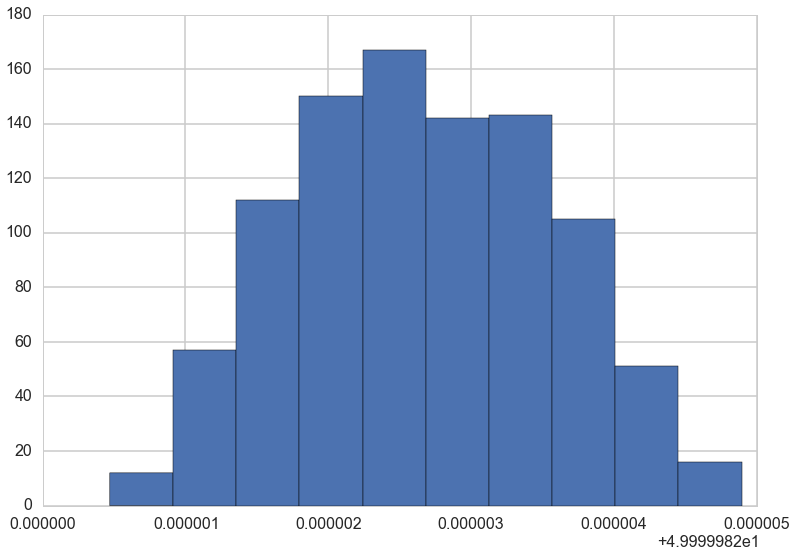

In [726]:
plt.hist(clflog1.predict_proba(Xtest)[:,1]*100);

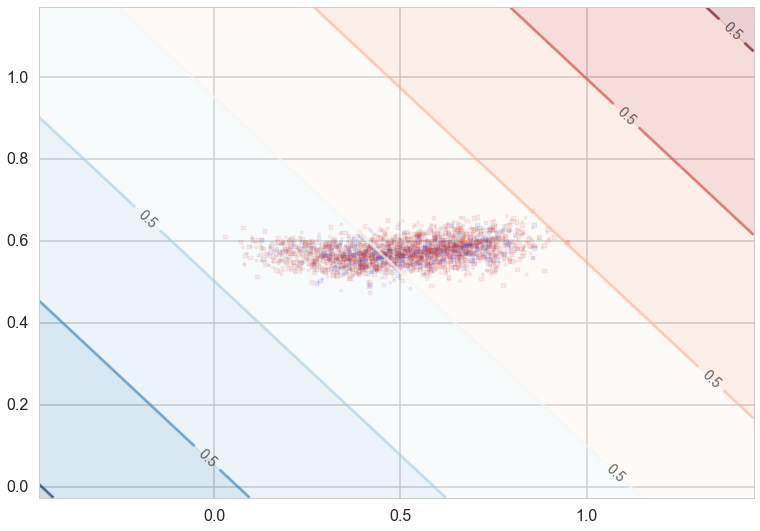

In [727]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog1, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog1);

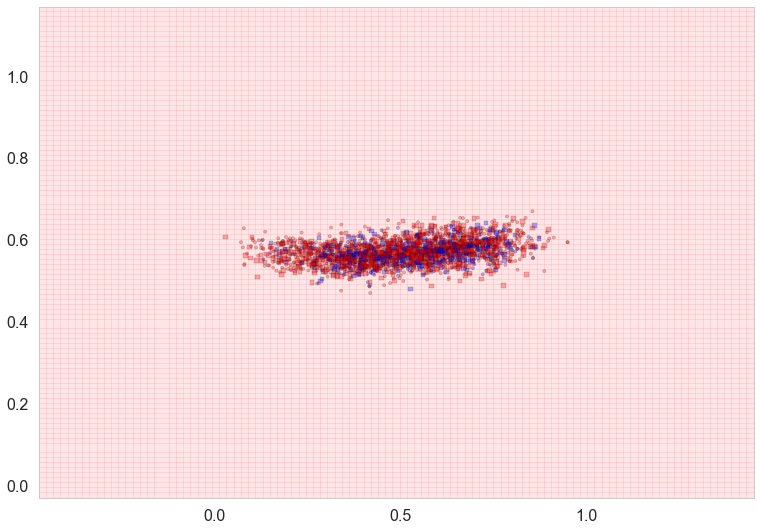

In [823]:
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1);

using mask
BEST {'C': 0.001} 0.77094972067 [mean: 0.77095, std: 0.00115, params: {'C': 0.001}, mean: 0.77095, std: 0.00115, params: {'C': 0.01}, mean: 0.77095, std: 0.00115, params: {'C': 0.1}, mean: 0.77095, std: 0.00115, params: {'C': 1}, mean: 0.77095, std: 0.00115, params: {'C': 10}, mean: 0.77095, std: 0.00115, params: {'C': 100}, mean: 0.77095, std: 0.00115, params: {'C': 1000}]
############# based on standard predict ################
Accuracy on training data: 0.77
Accuracy on test data:     0.79
[[757   0]
 [198   0]]
########################################################


/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


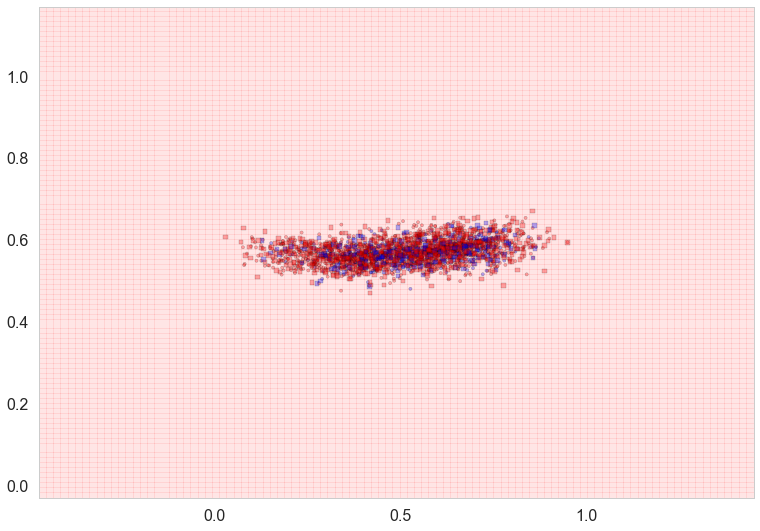

In [730]:
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1);

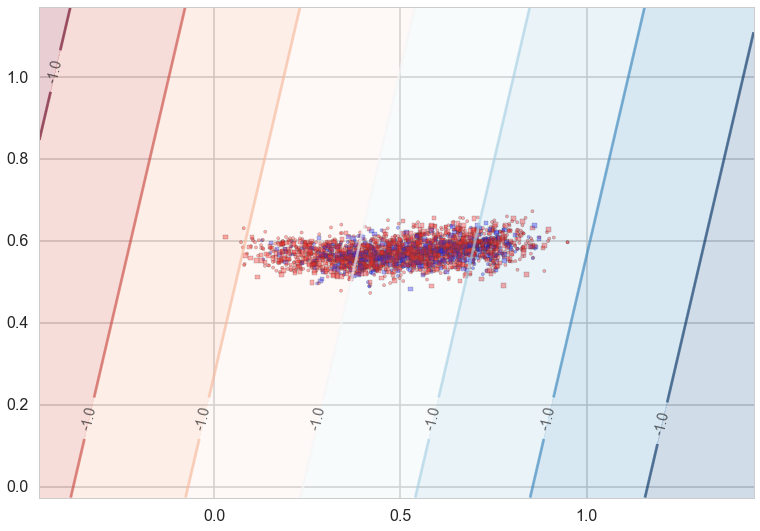

In [829]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1, prob=False);

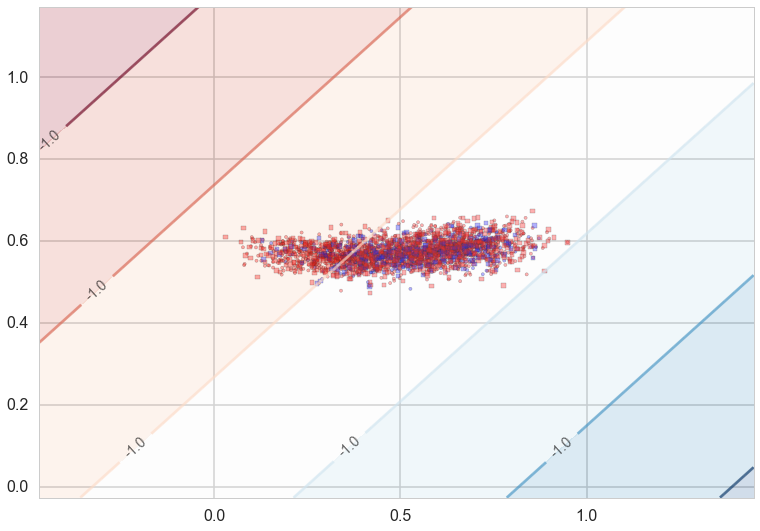

In [731]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1, prob=False);

In [682]:
#From Jake Vanderplas's ESAC notebook
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

(125, 225)

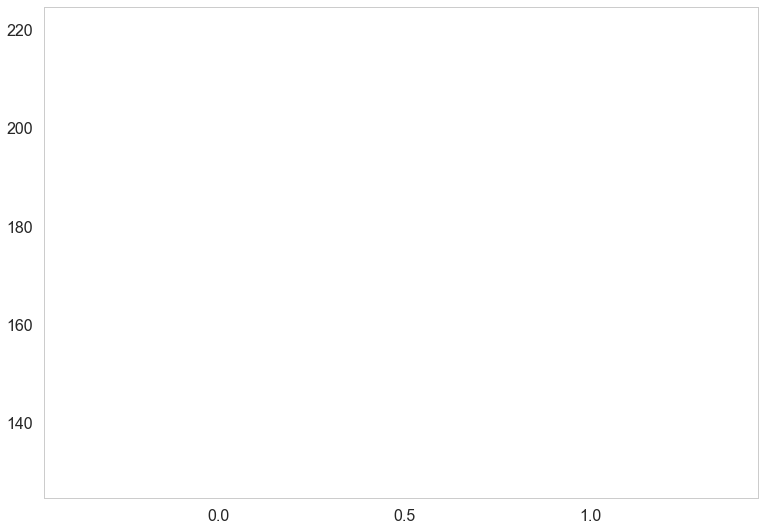

In [683]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm1);
plot_svc_decision_function(clfsvm1, ax)
ax.scatter(clfsvm1.support_vectors_[:, 0], clfsvm1.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

using mask


/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

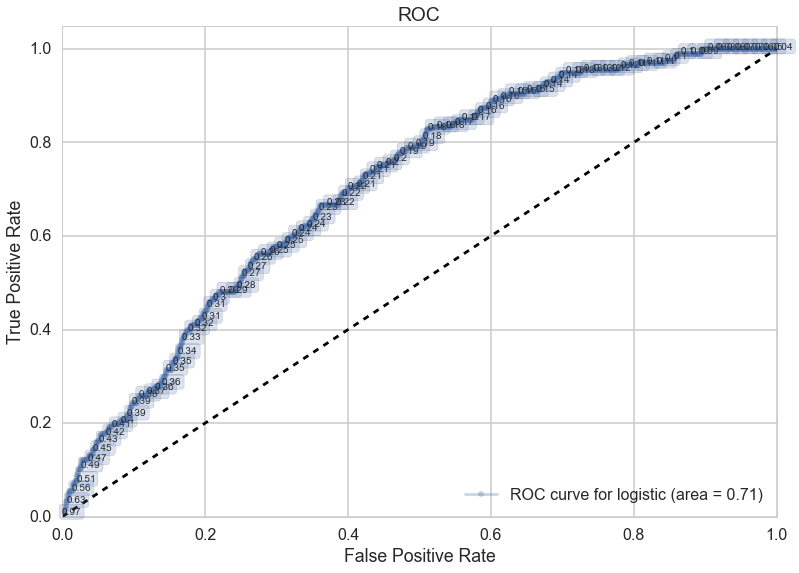

In [734]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog2, ytest, Xtest, labe=10)


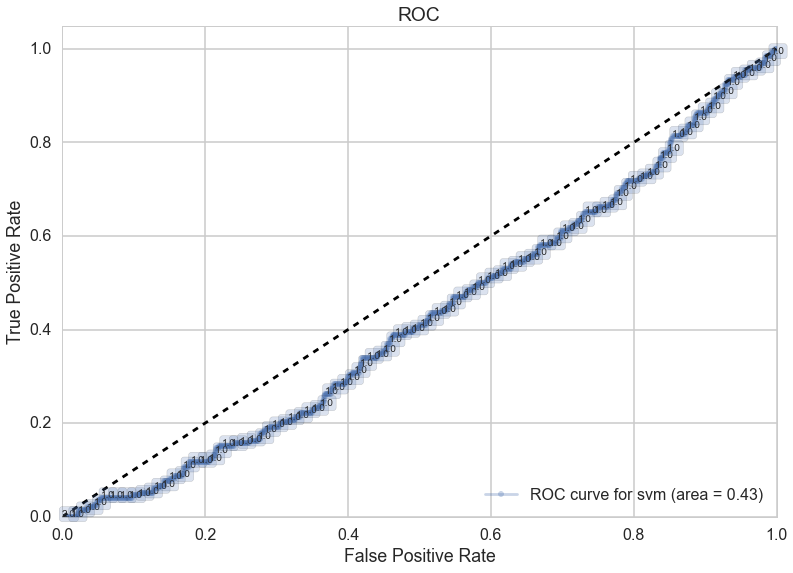

In [735]:
ax=make_roc("svm", clfsvm2, ytest, Xtest, labe=10, proba=False)

In [736]:
from sklearn import tree
clfTree1 = tree.DecisionTreeClassifier()

parameters_tree = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

clfTree1, Xtrain, ytrain, Xtest, ytest=do_classify(clfTree1, parameters_tree, dftouse, 
                                                 two_features,
                                                 'adj_opening_gross_bin', 1, mask=mask_classify)

using mask
BEST {'max_depth': 1, 'min_samples_leaf': 1} 0.77094972067 [mean: 0.77095, std: 0.00115, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: 0.77095, std: 0.00115, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: 0.77095, std: 0.00115, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: 0.77095, std: 0.00115, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: 0.77095, std: 0.00115, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: 0.77095, std: 0.00115, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: 0.77095, std: 0.00115, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: 0.77095, std: 0.00115, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: 0.77095, std: 0.00115, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: 0.77095, std: 0.00115, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: 0.77095, std: 0.00115, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: 0.77095, std: 0.00115, params: {'max_depth': 2, 'min_samples_leaf

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


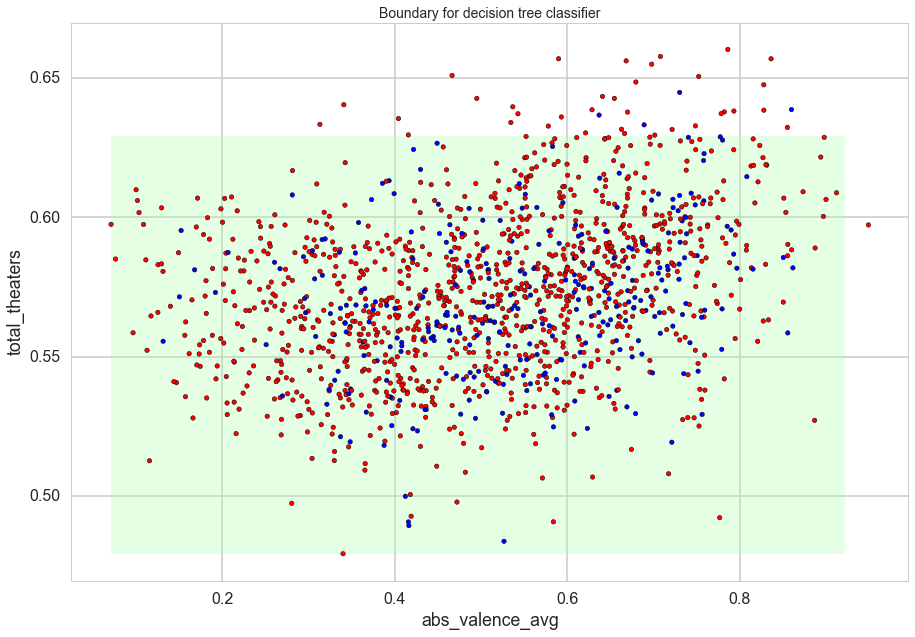

In [908]:
plot_2tree(plt, Xtrain, Xtest, ytrain, ytest, clfTree1, 
           lab = ['abs_valence_avg','total_theaters'], alpha = 1, plot_test = False)

In [743]:
clfAda2 = AdaBoostClassifier()

parameters_adaboost = {"n_estimators": range(10, 60)}
clfAda2, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda2, parameters_adaboost, 
                                                       dftouse, Xnames, 'adj_opening_gross_bin', 
                                                   1, mask=mask_classify)

using mask
BEST {'n_estimators': 11} 0.764664804469 [mean: 0.75349, std: 0.03102, params: {'n_estimators': 10}, mean: 0.76466, std: 0.01932, params: {'n_estimators': 11}, mean: 0.76257, std: 0.02971, params: {'n_estimators': 12}, mean: 0.75978, std: 0.02603, params: {'n_estimators': 13}, mean: 0.76187, std: 0.02550, params: {'n_estimators': 14}, mean: 0.75698, std: 0.02304, params: {'n_estimators': 15}, mean: 0.76047, std: 0.02383, params: {'n_estimators': 16}, mean: 0.75838, std: 0.02781, params: {'n_estimators': 17}, mean: 0.75908, std: 0.02648, params: {'n_estimators': 18}, mean: 0.75768, std: 0.02729, params: {'n_estimators': 19}, mean: 0.75559, std: 0.02610, params: {'n_estimators': 20}, mean: 0.75559, std: 0.02610, params: {'n_estimators': 21}, mean: 0.75279, std: 0.02482, params: {'n_estimators': 22}, mean: 0.75349, std: 0.02577, params: {'n_estimators': 23}, mean: 0.75279, std: 0.02548, params: {'n_estimators': 24}, mean: 0.75489, std: 0.02605, params: {'n_estimators': 25}, mea

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [744]:
from sklearn.ensemble import GradientBoostingClassifier

clfGB = GradientBoostingClassifier()

parameters_GB = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB, parameters_GB, 
                                                       dftouse, two_features, 'adj_opening_gross_bin', 1
                                                  , mask=mask_classify)

using mask
BEST {'n_estimators': 30, 'max_depth': 1} 0.77094972067 [mean: 0.77095, std: 0.00115, params: {'n_estimators': 30, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 31, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 32, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 33, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 34, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 35, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 36, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 37, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 38, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 39, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 40, 'max_depth': 1}, mean: 0.77095, std: 0.00115, params: {'n_estimators': 41, 'max_depth': 1}, mean: 0.77095, std: 0.00115, par

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [911]:
clfGB2 = GradientBoostingClassifier()

parameters_GB = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB2, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB2, parameters_GB, 
                                                       dftouse, Xnames, 'adj_opening_gross_bin', 1
                                                  , mask=mask_classify)

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[742   0]
 [212   0]]
########################################################


/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


ValueError: X has 2 features per sample; expecting 7

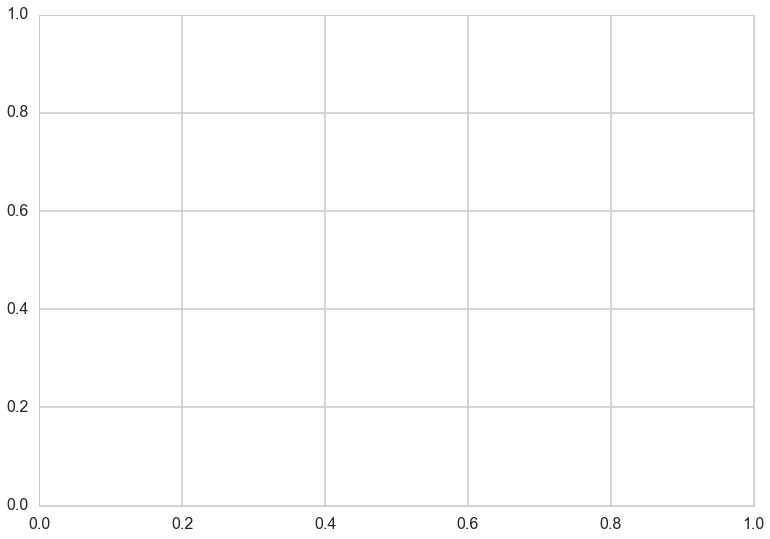

In [910]:
ax1=make_roc("log", clflog2, ytest, Xtest, labe=10, proba=False)
ax1=make_roc("svm", clfsvm2, ytest, Xtest, labe=10, proba=False)
ax1=make_roc("AdaBoost", clfAda2, ytest, Xtest, labe=10, proba=False)
ax1=make_roc("GB", clfGB2, ytest, Xtest, labe=10, proba=False)





In [558]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired)
    plt.show()
    
# your code here
imp_cols = clfforest2.feature_importances_.argsort()[::-1][0:2]

# This cell of code broke my kernel!


In [ ]:
X_imp = dftouse[imp_cols].values

for i in X_imp:
    for p in i:
        i[p] = int(i[p])

Y = dftouse.adj_opening_gross_bin.values
name_list = dftouse.columns

classifiers = [clfTree2,
               clfForest,
               clfAda,
               clfGB,
               sklearn.svm.SVC(C=100.0, gamma=1.0)]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier', 
                  'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Support Vector Machine']
for c in xrange(5):
    plt.title(titleClassifer[c])
    plt.xlabel(name_list[0])
    plt.ylabel(name_list[1])
    plot_decision_surface(classifiers[c], X_imp, dftouse.adj_opening_gross_bin.values)

In [912]:
clflog2 = LogisticRegression()
parameters_log = {"C": [0.000000001, 0.00000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,]}
clflog2, Xtrain, ytrain, Xtest, ytest=do_classify(clflog2, parameters_log, dftouse, 
                                                 Xnames,'adj_opening_gross_bin', 1, mask=mask_classify)
print ""


from sklearn.svm import SVC
clfsvm2 = SVC(kernel="linear")
parameters_svc = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm2, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm2, parameters_svc, dftouse, 
                                                 Xnames,'adj_opening_gross_bin', 1, mask=mask_classify)

print ""

from sklearn import tree
clfTree2 = tree.DecisionTreeClassifier()

parameters_tree = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

clfTree2, Xtrain, ytrain, Xtest, ytest=do_classify(clfTree2, parameters_tree, dftouse, 
                                                 Xnames,'adj_opening_gross_bin', 1, mask=mask_classify)

print ""



from sklearn.ensemble import AdaBoostClassifier

clfAda2 = AdaBoostClassifier()

parameters_adaboost = {"n_estimators": range(10, 60)}
clfAda2, Xtrain, ytrain, Xtest, ytest = do_classify(clfAda2, parameters_adaboost, 
                                                       dftouse, Xnames, 'adj_opening_gross_bin', 
                                                   1, mask=mask_classify)

print ""


from sklearn.ensemble import GradientBoostingClassifier

clfGB2 = GradientBoostingClassifier()

parameters_GB = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB2, Xtrain, ytrain, Xtest, ytest = do_classify(clfGB2, parameters_GB, dftouse, 
                                                   Xnames, 'adj_opening_gross_bin', 1, mask=mask_classify)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
using mask
############# based on standard predict ################
Accuracy on training data: 0.78
Accuracy on test data:     0.78
[[742   0]
 [212   0]]
########################################################

<class 'sklearn.svm.classes.SVC'>
using mask


/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


KeyboardInterrupt: 

# LolMethods* regression

###### *LolMethods trademarked under Dong Productions

Now we will begin our analysis of seeing to what extent we can predict opening gross of movies using the features we have, namely the following:

(all variables and explanation of variables)

We are going to use several regression methods, namely
1. Linear regression
2. Support Vector Machine Regression
3. Decision Tree Regression
4. Random Forest Regression
5. AdaBooster Regression
6. GradientBooster Regression

For methods 2-6, we will train these data and optimize it given some parameters. We will test the accuracy score of all of the classifiers and find the best one.

We begin by defining functions do_regress which takes a regressor from and optimize it over the parameters, then printing the training and testing accuracy scores as well as 

In [849]:
def do_regress(clf, parameters, indf, featurenames, targetname, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname]
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
#     print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [847]:
# linear regression
from sklearn.linear_model import LinearRegression

clflinear_reg = LinearRegression()

Xlin = dftouse[Xnames].values
ylin = dftouse['adj_opening_gross']
clflinear_reg = clflinear_reg.fit(Xlin[mask_classify], ylin[mask_classify])
training_accuracy = clflinear_reg.score(Xlin[mask_classify], ylin[mask_classify])
test_accuracy = clflinear_reg.score(Xlin[~mask_classify], ylin[~mask_classify])


print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print "########################################################"

############# based on standard predict ################
Accuracy on training data: 0.11
Accuracy on test data:     0.09
########################################################


In [850]:
# SVC regression

from sklearn.svm import SVR
parameters_svr = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvr_reg = SVR(kernel="linear")
clfsvr_reg, Xtrain, ytrain, Xtest, ytest = do_regress(clfsvr_reg, parameters_svr, 
                                                       dftouse, Xnames, 'adj_opening_gross', mask=mask_classify)

from sklearn.tree import DecisionTreeRegressor
parameters_tree = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clftree_reg = DecisionTreeRegressor()
clftree_reg, Xtrain, ytrain, Xtest, ytest = do_regress(clftree_reg, parameters_tree, 
                                                       dftouse, Xnames, 'adj_opening_gross', mask=mask_classify)



using mask
############# based on standard predict ################
Accuracy on training data: 0.01
Accuracy on test data:     -0.01
########################################################
using mask
############# based on standard predict ################
Accuracy on training data: 0.24
Accuracy on test data:     -0.14
########################################################


/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [607]:
# tree regression

from sklearn.tree import DecisionTreeRegressor
parameters_tree = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clftree_reg = DecisionTreeRegressor()
clftree_reg, Xtrain, ytrain, Xtest, ytest = do_regress(clftree_reg, parameters_tree, 
                                                       dftouse, Xnames, 'adj_opening_gross', mask=mask_classify)



using mask
BEST {'max_depth': 5, 'min_samples_leaf': 1} -1.88868945784 [mean: -16.16878, std: 22.18118, params: {'max_depth': 1, 'min_samples_leaf': 1}, mean: -8.59666, std: 13.08927, params: {'max_depth': 1, 'min_samples_leaf': 2}, mean: -11.79788, std: 13.55627, params: {'max_depth': 1, 'min_samples_leaf': 3}, mean: -13.44591, std: 16.21386, params: {'max_depth': 1, 'min_samples_leaf': 4}, mean: -13.30506, std: 16.32336, params: {'max_depth': 1, 'min_samples_leaf': 5}, mean: -11.96409, std: 14.15383, params: {'max_depth': 1, 'min_samples_leaf': 6}, mean: -17.29537, std: 25.61921, params: {'max_depth': 2, 'min_samples_leaf': 1}, mean: -9.59070, std: 11.50967, params: {'max_depth': 2, 'min_samples_leaf': 2}, mean: -20.27206, std: 21.98960, params: {'max_depth': 2, 'min_samples_leaf': 3}, mean: -17.13002, std: 18.73648, params: {'max_depth': 2, 'min_samples_leaf': 4}, mean: -15.18840, std: 16.95649, params: {'max_depth': 2, 'min_samples_leaf': 5}, mean: -14.46696, std: 15.92213, params:

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [616]:
# Random forest regression

from sklearn.ensemble import RandomForestRegressor
parameters_forest = {"n_estimators": range(1, len(Xnames))}
clfforest_1 = RandomForestRegressor()
clfforest_1, Xtrain, ytrain, Xtest, ytest = do_regress(clfforest_1, parameters_forest, 
                                                       dftouse, Xnames, 'adj_opening_gross', mask=mask_classify)


using mask
BEST {'n_estimators': 16} -1.60344713196 [mean: -14.17733, std: 23.91150, params: {'n_estimators': 1}, mean: -7.55901, std: 9.83886, params: {'n_estimators': 2}, mean: -4.04252, std: 4.14236, params: {'n_estimators': 3}, mean: -5.84855, std: 6.26774, params: {'n_estimators': 4}, mean: -3.15248, std: 3.63569, params: {'n_estimators': 5}, mean: -4.73092, std: 5.86358, params: {'n_estimators': 6}, mean: -5.32649, std: 7.05434, params: {'n_estimators': 7}, mean: -3.86260, std: 4.75277, params: {'n_estimators': 8}, mean: -2.70596, std: 4.49234, params: {'n_estimators': 9}, mean: -4.48253, std: 4.95461, params: {'n_estimators': 10}, mean: -4.36038, std: 6.29846, params: {'n_estimators': 11}, mean: -3.20156, std: 3.70206, params: {'n_estimators': 12}, mean: -3.13983, std: 2.95045, params: {'n_estimators': 13}, mean: -8.63215, std: 12.23841, params: {'n_estimators': 14}, mean: -3.81909, std: 3.89677, params: {'n_estimators': 15}, mean: -1.60345, std: 1.77334, params: {'n_estimators'

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [619]:
# AdaBoost Regression
from sklearn.ensemble import AdaBoostRegressor
clfAda_regress = AdaBoostRegressor()

parameters_adaboost = {"n_estimators": range(10, 60)}
clfAda_regress, Xtrain, ytrain, Xtest, ytest = do_regress(clfAda_regress, parameters_adaboost, 
                                                       dftouse, two_features, 'adj_opening_gross_bin', 
                                                          mask=mask_classify)

using mask
BEST {'n_estimators': 55} -0.615812298185 [mean: -0.99040, std: 1.08111, params: {'n_estimators': 10}, mean: -0.82215, std: 1.21707, params: {'n_estimators': 11}, mean: -1.07687, std: 0.91820, params: {'n_estimators': 12}, mean: -1.28543, std: 1.10741, params: {'n_estimators': 13}, mean: -1.03989, std: 0.90455, params: {'n_estimators': 14}, mean: -1.50957, std: 1.28922, params: {'n_estimators': 15}, mean: -0.89698, std: 0.97830, params: {'n_estimators': 16}, mean: -0.86528, std: 0.92934, params: {'n_estimators': 17}, mean: -1.08642, std: 1.04064, params: {'n_estimators': 18}, mean: -0.98527, std: 1.12353, params: {'n_estimators': 19}, mean: -1.01715, std: 1.14970, params: {'n_estimators': 20}, mean: -0.98842, std: 1.14266, params: {'n_estimators': 21}, mean: -1.26775, std: 1.04776, params: {'n_estimators': 22}, mean: -1.00766, std: 1.10114, params: {'n_estimators': 23}, mean: -1.07483, std: 1.10502, params: {'n_estimators': 24}, mean: -1.08145, std: 1.03409, params: {'n_esti

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [620]:
from sklearn.ensemble import GradientBoostingRegressor

clfGB_regress = GradientBoostingRegressor()

parameters_GB = {"n_estimators": range(30, 60), "max_depth": [1, 2, 3, 4, 5]}
clfGB_regress, Xtrain, ytrain, Xtest, ytest = do_regress(clfGB_regress, parameters_GB, 
                                                       dftouse, two_features, 'adj_opening_gross_bin'
                                                  , mask=mask_classify)

using mask
BEST {'n_estimators': 33, 'max_depth': 2} -0.685368253819 [mean: -0.98302, std: 0.92234, params: {'n_estimators': 30, 'max_depth': 1}, mean: -0.99163, std: 0.89672, params: {'n_estimators': 31, 'max_depth': 1}, mean: -0.99437, std: 0.90677, params: {'n_estimators': 32, 'max_depth': 1}, mean: -0.98571, std: 0.91202, params: {'n_estimators': 33, 'max_depth': 1}, mean: -0.96478, std: 0.92225, params: {'n_estimators': 34, 'max_depth': 1}, mean: -0.97269, std: 0.89609, params: {'n_estimators': 35, 'max_depth': 1}, mean: -0.94272, std: 0.92586, params: {'n_estimators': 36, 'max_depth': 1}, mean: -0.94434, std: 0.91540, params: {'n_estimators': 37, 'max_depth': 1}, mean: -0.93931, std: 0.91487, params: {'n_estimators': 38, 'max_depth': 1}, mean: -0.96588, std: 0.89237, params: {'n_estimators': 39, 'max_depth': 1}, mean: -0.92761, std: 0.91805, params: {'n_estimators': 40, 'max_depth': 1}, mean: -0.95707, std: 0.87717, params: {'n_estimators': 41, 'max_depth': 1}, mean: -0.92971, st

/Users/jasondong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### Visualization

## Milestone 3: Video and finishing touches

### Screencast video

### Website

### Finishing touches

Our analysis seems to show that valence is not a good predictor of grossing for movies. This is perhaps because our valence values are not representative of the reviews.

At this stage, we would like at least establish a relationship between movie grossing and review